# MARKET MIX MODELING

Marketing Mix Model uses historical data (such as sales, costs of all past ad campaigns, and RoI) and regression techniques to tease out each channel’s contribution towards your KPI. This is essentially done by identifying the variations in channel spend and the corresponding variations in the KPI.

*   which is the most frequently used channel
*   how much sales in X weeks was generated by a.b.c channels and what is the baseline i.e the sales generated without any ads

*   for business we need ROI so we use additive models coz our seasonal fluctuations do not vary with the level of the time series
*   yt = trend*t + season*s + irregularity*e

*   Here the sales is trerated as the function of Base sales and marketing variables as
> Sales = f(Facebook) + g(Google) + ... + Base

















### References:


*   https://towardsdatascience.com/an-upgraded-marketing-mix-modeling-in-python-5ebb3bddc1b6
*   https://towardsdatascience.com/improving-marketing-mix-modeling-using-machine-learning-approaches-25ea4cd6994b

*   https://towardsdatascience.com/improving-marketing-mix-modeling-using-machine-learning-approaches-25ea4cd6994b
*   https://www.youtube.com/playlist?list=PLdaWFt7A-Gf0gVU-9ctY_SqKkfYD8Bdob

*   https://github.com/abhinav1024/Marketing_Mix_Modelling-MMM-/blob/main/E-Commerce_MMM_Project_final.ipynb
   







### Importing the required Libraries

In [ ]:
# import libraries
import pandas as pd
import datetime as dt
import numpy as np
from datetime import datetime

# import for google colab
#from google.colab import files
#from google.colab import drive

# For Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import matplotlib
from matplotlib import pyplot
import plotly.express as px
import plotly.graph_objects as go

# Supress Warnings
import warnings
#import itertools
warnings.filterwarnings('ignore')

# Pandas Settings
# pd.options.display.float_format = '{:.1f}'.format
pd.set_option('display.max_rows', 40000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Miscellaneous imports
from datetime import datetime
from scipy.stats import norm
import re

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.datasets import make_regression
from sklearn.model_selection import GridSearchCV
from statsmodels.stats.outliers_influence import variance_inflation_factor
import math
from math import sqrt
from sklearn.metrics import mean_squared_error, r2_score
from datetime import date,timedelta

from sklearn.model_selection import KFold, cross_val_score, TimeSeriesSplit
from sklearn.linear_model import LinearRegression, Ridge, Lasso
#from sklearn.neighbors import KNeighborsRegressor
#from sklearn.tree import DecisionTreeRegressor
#from sklearn.ensemble import (RandomForestRegressor, GradientBoostingRegressor, 
#                              AdaBoostRegressor)
#from sklearn.svm import SVR
#from sklearn.linear_model import SGDRegressor
#from xgboost import XGBRegressor
#from xgboost import plot_importance


In [ ]:
#from statsmodels.graphics.tsaplots import plot_acf
#from statsmodels.graphics.tsaplots import plot_pacf
#from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA, ARIMA
#from pyramid.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
#from fbprophet import Prophet

#from math import sqrt

#import matplotlib
#matplotlib.rcParams['axes.labelsize'] = 14
#matplotlib.rcParams['xtick.labelsize'] = 12
#matplotlib.rcParams['ytick.labelsize'] = 12
#matplotlib.rcParams['text.color'] = 'k'

from random import random

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error

### Defining the functions  

In [ ]:
def week_of_month(dt):
    """ Returns the week of the month for the specified date.
    """

    first_day = dt.replace(day=1)

    dom = dt.day
    adjusted_dom = dom + first_day.weekday()

    return int(ceil(adjusted_dom/7.0))

# Decomposition
def decompose(df,col,period,model):
    decomposition = sm.tsa.seasonal_decompose(df[col],period = 12,model=model) 
    figure = decomposition.plot()
    plt.show()
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residaul = decomposition.resid
    #residual_df = [x for x in globals() if globals()[x] is df][0]
    #return residaul
    return trend
    
    
    
# Adfuller Test
def adftest(df_col):
    result = adfuller(df_col)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print(f'Critical Values:')
    for key,val in result[4].items():
        print(f'{key} {val}')

# Plot ACF and PACF
def plot_apacf(df_col,lags):
    plot_acf(df_col, lags=lags)
    plt.show()
    plot_pacf(df_col,lags=lags)
    plt.show()
    
# Check VIF
def checkVIF(df,cols):
    vif_data = pd.DataFrame()
    X = df[cols]
    vif_data["feature"] = X.columns
  
    # calculating VIF for each feature
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
    return vif_data

## Doing Log Transformations
def logTransform(df,cols):
    temp = df.copy()
    arr = []
    for j in cols:
        temp[f'ln_{j}'] = np.log(temp[j])
        arr.append(f'ln_{j}')
    return(temp,arr)

## Doing Detrending of the data 
def detrending(df):
  loc_index = df.columns.get_loc('burger_sales') + 1
  df.insert(loc=loc_index,column = 'burger_sales_detrend', value = df['burger_sales'] - df['burger_sales'].shift(1))

### Reading Data 

In [ ]:
main_df = pd.read_csv('Burger_Sales.csv')

main_df.head()

Date  burger_sales  Instagram_Cost  Bing_Cost  Facebook_Cost  Google_Cost  Pinterest_Cost  Tiktok Cost
0  2020-01-01           950             0.0        0.0         1041.1       4447.4             0.0          0.0
1  2020-01-02          1340           582.5        0.0         2597.0       6561.1             0.0          0.0
2  2020-01-03          1370           551.5        0.0         2580.0       6500.3             0.0          0.0
3  2020-01-04          1160             0.0        0.0         2245.5       6499.6             0.0          0.0
4  2020-01-05          1070           540.0        0.0         1751.1       6499.1             0.0          0.0

### Cleaning Data 

In [ ]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 850 entries, 0 to 849
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            850 non-null    datetime64[ns]
 1   burger_sales    850 non-null    int64         
 2   Instagram_Cost  850 non-null    float64       
 3   Bing_Cost       850 non-null    float64       
 4   Facebook_Cost   850 non-null    float64       
 5   Google_Cost     850 non-null    float64       
 6   Pinterest_Cost  850 non-null    float64       
 7   Tiktok Cost     850 non-null    float64       
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 53.2 KB


In [ ]:
#Correcting Data Types
main_df['Date'] =  pd.to_datetime(main_df['Date'], format='%Y-%m-%d')

In [ ]:
# Unique value frequencies
unique_values = pd.DataFrame(main_df.apply(lambda x: len(x.value_counts(dropna=False)), axis=0), columns=['Unique Value Count']).sort_values(by='Unique Value Count', ascending=True)
unique_values['dtype'] = pd.DataFrame(main_df.dtypes)
unique_values

Unique Value Count           dtype
Pinterest_Cost                   8         float64
Tiktok Cost                     84         float64
burger_sales                   528           int64
Instagram_Cost                 612         float64
Bing_Cost                      617         float64
Facebook_Cost                  825         float64
Date                           850  datetime64[ns]
Google_Cost                    850         float64

In [ ]:
initial_shape = main_df.shape
initial_shape

(850, 8)

In [ ]:
main_df.describe().round(0)

burger_sales  Instagram_Cost  Bing_Cost  Facebook_Cost  Google_Cost  Pinterest_Cost  Tiktok Cost
count         850.0           850.0      850.0          850.0        850.0           850.0        850.0
mean         5552.0          1533.0     8811.0         9399.0      83312.0           190.0       2954.0
std          3475.0          3225.0    13524.0        19097.0      90478.0          2100.0       7892.0
min           950.0             0.0        0.0            0.0       1384.0             0.0          0.0
25%          2082.0           548.0        0.0          694.0       6163.0             0.0          0.0
50%          5705.0           987.0     4446.0         2515.0      60889.0             0.0          0.0
75%          8535.0          1611.0    11576.0        11246.0     131052.0             0.0          0.0
max         14880.0         31764.0   100594.0       220378.0     414996.0         25803.0      37642.0

In [ ]:
main_df['Date'].describe()

count                     850
unique                    850
top       2020-01-01 00:00:00
freq                        1
first     2020-01-01 00:00:00
last      2022-05-31 00:00:00
Name: Date, dtype: object

## Feature Engineering  

In [ ]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 850 entries, 0 to 849
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            850 non-null    datetime64[ns]
 1   burger_sales    850 non-null    int64         
 2   Instagram_Cost  850 non-null    float64       
 3   Bing_Cost       850 non-null    float64       
 4   Facebook_Cost   850 non-null    float64       
 5   Google_Cost     850 non-null    float64       
 6   Pinterest_Cost  850 non-null    float64       
 7   Tiktok Cost     850 non-null    float64       
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 53.2 KB


In [ ]:
# Creating a new column "Daily Investment = Sum of all channels" into a specific position in a DataFrame
loc_index = main_df.columns.get_loc('burger_sales') + 1
main_df.insert(loc=loc_index,column='Daily_Investment',value = main_df['Instagram_Cost'] + main_df['Bing_Cost'] + main_df['Facebook_Cost'] + main_df['Google_Cost']+ main_df['Pinterest_Cost'] + main_df['Tiktok Cost'])
main_df.head()
main_df.head()

Date  burger_sales  Daily_Investment  Instagram_Cost  Bing_Cost  Facebook_Cost  Google_Cost  Pinterest_Cost  Tiktok Cost
0 2020-01-01           950            5488.5             0.0        0.0         1041.1       4447.4             0.0          0.0
1 2020-01-02          1340            9740.6           582.5        0.0         2597.0       6561.1             0.0          0.0
2 2020-01-03          1370            9631.8           551.5        0.0         2580.0       6500.3             0.0          0.0
3 2020-01-04          1160            8745.1             0.0        0.0         2245.5       6499.6             0.0          0.0
4 2020-01-05          1070            8790.2           540.0        0.0         1751.1       6499.1             0.0          0.0

### Statistical Info
Distribution of the numeric columns

In [ ]:
main_df.describe().round(0).T

count      mean       std     min     25%      50%       75%       max
burger_sales      850.0    5552.0    3475.0   950.0  2082.0   5705.0    8535.0   14880.0
Daily_Investment  850.0  106200.0  120442.0  2039.0  8816.0  73169.0  162237.0  570236.0
Instagram_Cost    850.0    1533.0    3225.0     0.0   548.0    987.0    1611.0   31764.0
Bing_Cost         850.0    8811.0   13524.0     0.0     0.0   4446.0   11576.0  100594.0
Facebook_Cost     850.0    9399.0   19097.0     0.0   694.0   2515.0   11246.0  220378.0
Google_Cost       850.0   83312.0   90478.0  1384.0  6163.0  60889.0  131052.0  414996.0
Pinterest_Cost    850.0     190.0    2100.0     0.0     0.0      0.0       0.0   25803.0
Tiktok Cost       850.0    2954.0    7892.0     0.0     0.0      0.0       0.0   37642.0

#############
burger_sales
#############


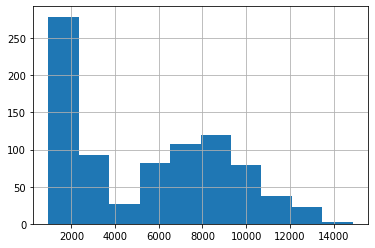

#############
Daily_Investment
#############


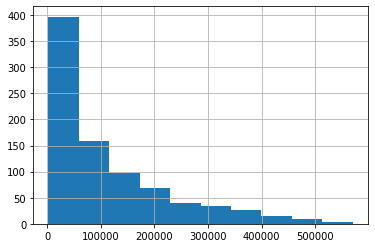

#############
Instagram_Cost
#############


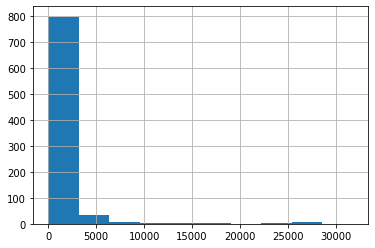

#############
Bing_Cost
#############


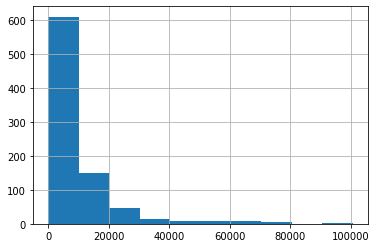

#############
Facebook_Cost
#############


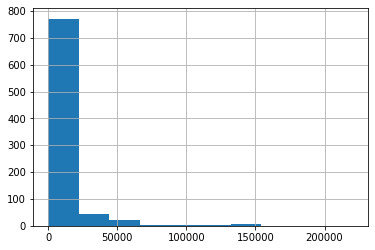

#############
Google_Cost
#############


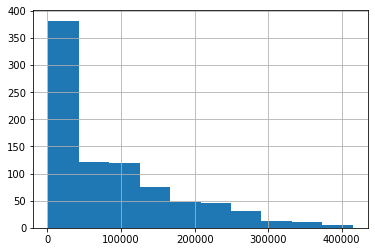

#############
Pinterest_Cost
#############


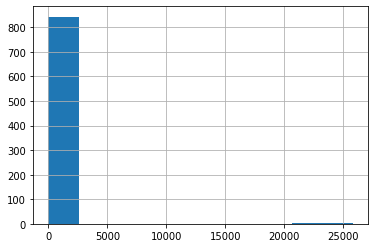

#############
Tiktok Cost
#############


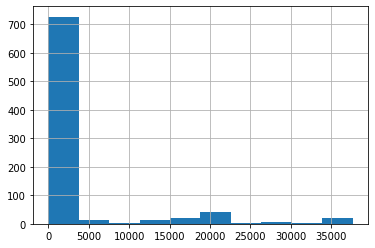

In [ ]:
for col in main_df.describe().columns:
    print('#############')
    print(col)
    print('#############')
    main_df[col].hist()
    plt.show()

### Outlier Treatment

In [ ]:
main_df.columns

Index(['Date', 'burger_sales', 'Daily_Investment', 'Instagram_Cost', 'Bing_Cost', 'Facebook_Cost', 'Google_Cost', 'Pinterest_Cost', 'Tiktok Cost'], dtype='object')

In [ ]:
# Function to plot the distribution plot of the numeric variable list

numeric_variables=['burger_sales', 'Daily_Investment', 'Instagram_Cost', 'Bing_Cost', 'Facebook_Cost', 'Google_Cost', 'Pinterest_Cost', 'Tiktok Cost']

#Function to plot the distribution plot of the numeric variable list
def univariate_continuos(var_list):
    plt.figure(figsize=(12,6))
    for var in var_list:
        plt.subplot(2,4,var_list.index(var)+1)
        #plt.boxplot(country[var])
        sns.boxplot(y=var,palette='cubehelix', data=main_df)
    # Automatically adjust subplot params so that the subplotS fits in to the figure area.
    plt.tight_layout()
    # display the plot
    plt.show()

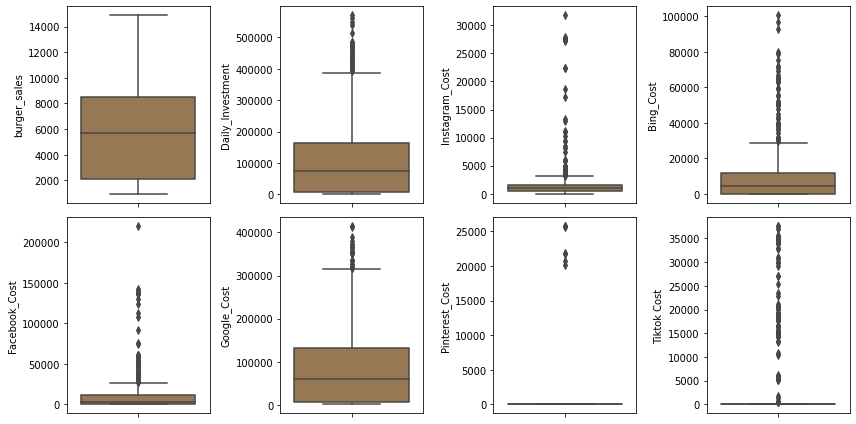

In [ ]:
univariate_continuos(numeric_variables)

In [ ]:
# Checking outliers at 25%,50%,75%,90%,95% and 99%

main_df[numeric_variables].describe(percentiles=[.25,.5,.75,.90,.95,.99]).round(0).T

count      mean       std     min     25%      50%       75%       90%       95%       99%       max
burger_sales      850.0    5552.0    3475.0   950.0  2082.0   5705.0    8535.0   10143.0   11336.0   13091.0   14880.0
Daily_Investment  850.0  106200.0  120442.0  2039.0  8816.0  73169.0  162237.0  290535.0  361969.0  474165.0  570236.0
Instagram_Cost    850.0    1533.0    3225.0     0.0   548.0    987.0    1611.0    2436.0    4114.0   22379.0   31764.0
Bing_Cost         850.0    8811.0   13524.0     0.0     0.0   4446.0   11576.0   21669.0   31269.0   68206.0  100594.0
Facebook_Cost     850.0    9399.0   19097.0     0.0   694.0   2515.0   11246.0   20274.0   39720.0  118788.0  220378.0
Google_Cost       850.0   83312.0   90478.0  1384.0  6163.0  60889.0  131052.0  223315.0  269288.0  355388.0  414996.0
Pinterest_Cost    850.0     190.0    2100.0     0.0     0.0      0.0       0.0       0.0       0.0       0.0   25803.0
Tiktok Cost       850.0    2954.0    7892.0     0.0     0.0      0.0       0.0   16500.0   20500.0   35322.0   37642.0

In [ ]:
#Percentage of Outliers in column deliverybdays is
#print('Percentage of Outliers in column deliverybdays is ',round(100*(main_df.loc[main_df['deliverybdays'] > 8.0].shape[0] / main_df.shape[0]),4))
#Percentage of Outliers in column deliverycdays is
#print('Percentage of Outliers in column deliverycdays',round(100*(main_df.loc[main_df['deliverycdays'] > 10.0].shape[0] / main_df.shape[0]),4))
#Percentage of Outliers in column sla
#print('Percentage of Outliers in column sla is ',round(100*(main_df.loc[main_df['sla'] > 13.0].shape[0] / main_df.shape[0]),4))

CAP the values above 99 percentile to the value corresponding to 99 percentile.

In [ ]:
print('Records that have been retained after outlier treatment is',round(100*(main_df.shape[0] / initial_shape[0])))

Records that have been retained after outlier treatment is 100


In [ ]:
# Checking outliers at 25%,50%,75%,90%,95% and 99%

main_df.describe(percentiles=[.25,.5,.75,.90,.95,.99]).round(0).T

count      mean       std     min     25%      50%       75%       90%       95%       99%       max
burger_sales      850.0    5552.0    3475.0   950.0  2082.0   5705.0    8535.0   10143.0   11336.0   13091.0   14880.0
Daily_Investment  850.0  106200.0  120442.0  2039.0  8816.0  73169.0  162237.0  290535.0  361969.0  474165.0  570236.0
Instagram_Cost    850.0    1533.0    3225.0     0.0   548.0    987.0    1611.0    2436.0    4114.0   22379.0   31764.0
Bing_Cost         850.0    8811.0   13524.0     0.0     0.0   4446.0   11576.0   21669.0   31269.0   68206.0  100594.0
Facebook_Cost     850.0    9399.0   19097.0     0.0   694.0   2515.0   11246.0   20274.0   39720.0  118788.0  220378.0
Google_Cost       850.0   83312.0   90478.0  1384.0  6163.0  60889.0  131052.0  223315.0  269288.0  355388.0  414996.0
Pinterest_Cost    850.0     190.0    2100.0     0.0     0.0      0.0       0.0       0.0       0.0       0.0   25803.0
Tiktok Cost       850.0    2954.0    7892.0     0.0     0.0      0.0       0.0   16500.0   20500.0   35322.0   37642.0

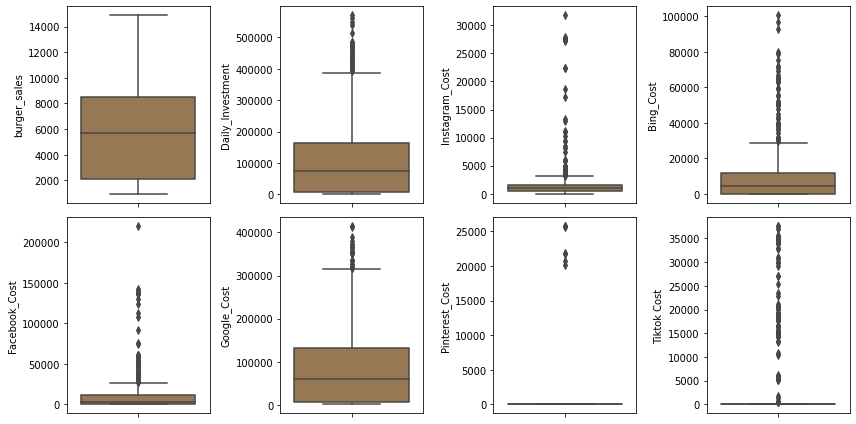

In [ ]:
univariate_continuos(numeric_variables)

### Skewness

Checking the skewness in the dataset

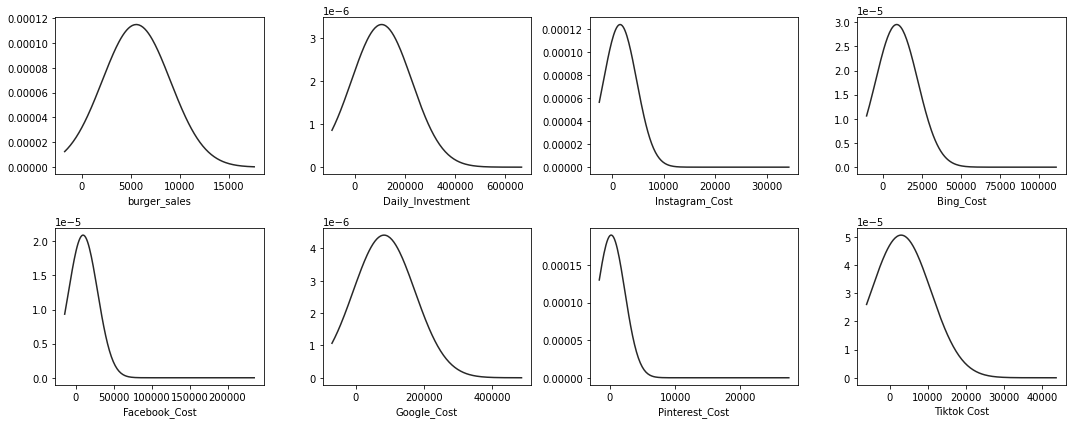

In [ ]:
num_col = ['burger_sales', 'Daily_Investment', 'Instagram_Cost', 'Bing_Cost', 'Facebook_Cost', 'Google_Cost', 'Pinterest_Cost', 'Tiktok Cost']


#Function to plot the distribution plot of the numeric variable list
def distplots(var_list):
    plt.figure(figsize=(15,6))
    for var in var_list:
        plt.subplot(2,4,var_list.index(var)+1)
        sns.distplot(main_df[var], fit=norm, kde=False, hist=False)
        #sns.boxplot(y=var,palette='cubehelix', data=main_df)
    # Automatically adjust subplot params so that the subplotS fits in to the figure area.
    plt.tight_layout()
    # display the plot
    plt.show()
    
distplots(num_col) 

### EDA & Visualization

In [ ]:
main_df.shape

(850, 9)

In [ ]:
main_df.set_index('Date', inplace = True, drop = True)
main_df.head()

burger_sales  Daily_Investment  Instagram_Cost  Bing_Cost  Facebook_Cost  Google_Cost  Pinterest_Cost  Tiktok Cost
Date                                                                                                                          
2020-01-01           950            5488.5             0.0        0.0         1041.1       4447.4             0.0          0.0
2020-01-02          1340            9740.6           582.5        0.0         2597.0       6561.1             0.0          0.0
2020-01-03          1370            9631.8           551.5        0.0         2580.0       6500.3             0.0          0.0
2020-01-04          1160            8745.1             0.0        0.0         2245.5       6499.6             0.0          0.0
2020-01-05          1070            8790.2           540.0        0.0         1751.1       6499.1             0.0          0.0

In [ ]:
fig = px.line(main_df, x =main_df.index, y = main_df.columns )
fig.update_layout(yaxis_title="Marketing Spending", legend_title=" Channel ", uniformtext_minsize=5, uniformtext_mode='show')
fig.update_xaxes(rangeslider_visible=True)
fig.show()

Resampling to Weekly Level

In [ ]:
weekly_group = main_df.resample('W').sum()
weekly_group.head()

burger_sales  Daily_Investment  Instagram_Cost  Bing_Cost  Facebook_Cost   Google_Cost  Pinterest_Cost  Tiktok Cost
Date                                                                                                                           
2020-01-05          5890       42396.20000          1674.0        0.0    10214.70000   30507.50000             0.0          0.0
2020-01-12         10850      138945.60000          4789.4        0.0    15701.90000  118454.30000             0.0          0.0
2020-01-19         11580      142896.34605          4152.7        0.0    19440.72415  119302.92190             0.0          0.0
2020-01-26         12500      111921.18072          4399.4        0.0    18577.15100   88944.62972             0.0          0.0
2020-02-02         12210      112436.37720          4063.7        0.0    16770.34063   91602.33657             0.0          0.0

In [ ]:
weekly_group.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 127 entries, 2020-01-05 to 2022-06-05
Freq: W-SUN
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   burger_sales      127 non-null    int64  
 1   Daily_Investment  127 non-null    float64
 2   Instagram_Cost    127 non-null    float64
 3   Bing_Cost         127 non-null    float64
 4   Facebook_Cost     127 non-null    float64
 5   Google_Cost       127 non-null    float64
 6   Pinterest_Cost    127 non-null    float64
 7   Tiktok Cost       127 non-null    float64
dtypes: float64(7), int64(1)
memory usage: 8.9 KB


PLotting the weekly sales data 

In [ ]:
fig = px.line(weekly_group, x = weekly_group.index, y = weekly_group.columns, title = 'Weekly Sales And Marketing Distribution'  )
fig.update_layout(yaxis_title="Marketing Spending", legend_title=" Channel ", uniformtext_minsize=5, uniformtext_mode='show')
fig.update_xaxes(rangeslider_visible=True)
fig.show()

Plotting the Yearly Distribution of Marketing Budget 

In [ ]:
main_df.columns[:-1]

Index(['burger_sales', 'Daily_Investment', 'Instagram_Cost', 'Bing_Cost', 'Facebook_Cost', 'Google_Cost', 'Pinterest_Cost'], dtype='object')

In [ ]:
labels = ['Instagram_Cost', 'Bing_Cost', 'Facebook_Cost', 'Google_Cost', 'Pinterest_Cost', 'Tiktok Cost']

In [ ]:
#fig = px.sunburst(main_df,labels=labels, path = main_df[labels], values=[main_df.loc["2020-01-01":"2020-12-31"][labels].sum(),main_df.loc["2021-01-01":"2021-12-31"][labels].sum(),main_df.loc["2022-01-01":][labels].sum()], color= labels)
#fig.show()

In [ ]:
Year = main_df.resample('Y').sum().T.round(2)
Year

Date              2020-12-31  2021-12-31   2022-12-31
burger_sales       754990.00   2785990.0   1178530.00
Daily_Investment  3463487.09  43473918.8  43332565.45
Instagram_Cost     111837.30    475525.0    716026.80
Bing_Cost          313130.50   3369720.6   3806719.40
Facebook_Cost      385810.27   2725521.0   4877502.33
Google_Cost       2652709.03  36847929.4  31314826.02
Pinterest_Cost          0.00         0.0    161682.20
Tiktok Cost             0.00     55222.8   2455808.70

In [ ]:
Year.columns.year

Int64Index([2020, 2021, 2022], dtype='int64', name='Date')

In [ ]:
Year = Year.loc[labels]

In [ ]:
Year.columns = ['2020', '2021', '2022']
Year

2020        2021         2022
Instagram_Cost   111837.30    475525.0    716026.80
Bing_Cost        313130.50   3369720.6   3806719.40
Facebook_Cost    385810.27   2725521.0   4877502.33
Google_Cost     2652709.03  36847929.4  31314826.02
Pinterest_Cost        0.00         0.0    161682.20
Tiktok Cost           0.00     55222.8   2455808.70

Creating Yearly Distribution of Marketing Spend

In [ ]:
fig = px.bar(Year, x = Year.index, y =['2020', '2021', '2022'], text_auto=True, title= 'Distribution of Marketing Spendings', barmode='group', height=400)
fig.update_layout(xaxis_title="Channel", yaxis_title="Marketing Spending", legend_title=" Year ", uniformtext_minsize=5, uniformtext_mode='show')
fig.update_layout(barmode='group', xaxis={'categoryorder': 'total descending'})
fig.update_traces(textposition='auto' ,textangle = 90)
fig.show()

Yearly Pie Chart

In [ ]:
fig = make_subplots(1, 3, specs=[[{'type':'domain'}, {'type':'domain'},{'type':'domain'}]],
                    subplot_titles=['2020', '2021', '2022' ])
fig.add_trace(go.Pie(labels=labels, values=main_df.loc["2020-01-01":"2020-12-31"][labels].sum(), 
                     name="Spending 2020"), 1, 1)
fig.add_trace(go.Pie(labels=labels, values=main_df.loc["2021-01-01":"2021-12-31"][labels].sum(), 
                     name="Spending 2021"), 1, 2)
fig.add_trace(go.Pie(labels=labels, values=main_df.loc["2022-01-01":][labels].sum(), 
                     name="Spending 2022"), 1, 3)

fig.update_traces(textposition='inside',textinfo='percent+label')
fig.update_layout(title_text='Marketing Spending')
fig.update_layout(uniformtext_minsize=8)


fig.show()

NameError: ignored

We can notice that top three channeles in terms of marketing expenditure were Google, Facebook & Bing

### Time Series Forecasting 

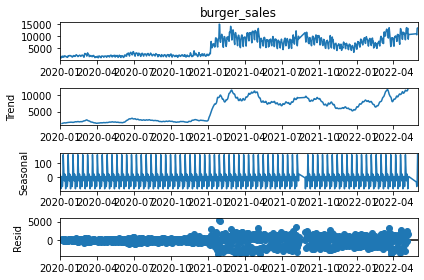

Date
2020-01-01         NaN
2020-01-02         NaN
2020-01-03         NaN
2020-01-04         NaN
2020-01-05         NaN
2020-01-06         NaN
2020-01-07    1427.500
2020-01-08    1485.833
2020-01-09    1525.000
2020-01-10    1558.333
2020-01-11    1603.750
2020-01-12    1638.333
2020-01-13    1631.667
2020-01-14    1607.917
2020-01-15    1602.083
2020-01-16    1593.750
2020-01-17    1608.750
2020-01-18    1654.167
2020-01-19    1682.917
2020-01-20    1695.417
2020-01-21    1713.750
2020-01-22    1740.000
2020-01-23    1755.833
2020-01-24    1774.583
2020-01-25    1805.000
2020-01-26    1824.583
2020-01-27    1817.917
2020-01-28    1814.583
2020-01-29    1822.500
2020-01-30    1825.417
2020-01-31    1817.500
2020-02-01    1799.583
2020-02-02    1776.667
2020-02-03    1755.417
2020-02-04    1765.000
2020-02-05    1802.500
2020-02-06    1843.333
2020-02-07    1890.000
2020-02-08    1935.000
2020-02-09    1948.750
2020-02-10    1931.667
2020-02-11    1911.250
2020-02-12    1919.583
2020-0

In [ ]:
decompose(main_df,'burger_sales',12,'additive')

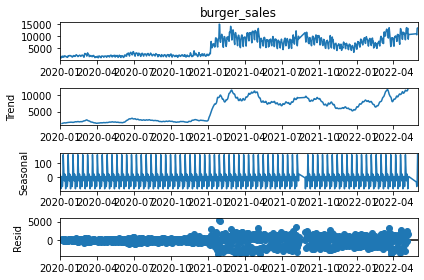

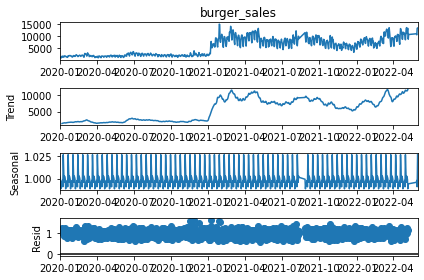

Date
2020-01-01         NaN
2020-01-02         NaN
2020-01-03         NaN
2020-01-04         NaN
2020-01-05         NaN
2020-01-06         NaN
2020-01-07    1427.500
2020-01-08    1485.833
2020-01-09    1525.000
2020-01-10    1558.333
2020-01-11    1603.750
2020-01-12    1638.333
2020-01-13    1631.667
2020-01-14    1607.917
2020-01-15    1602.083
2020-01-16    1593.750
2020-01-17    1608.750
2020-01-18    1654.167
2020-01-19    1682.917
2020-01-20    1695.417
2020-01-21    1713.750
2020-01-22    1740.000
2020-01-23    1755.833
2020-01-24    1774.583
2020-01-25    1805.000
2020-01-26    1824.583
2020-01-27    1817.917
2020-01-28    1814.583
2020-01-29    1822.500
2020-01-30    1825.417
2020-01-31    1817.500
2020-02-01    1799.583
2020-02-02    1776.667
2020-02-03    1755.417
2020-02-04    1765.000
2020-02-05    1802.500
2020-02-06    1843.333
2020-02-07    1890.000
2020-02-08    1935.000
2020-02-09    1948.750
2020-02-10    1931.667
2020-02-11    1911.250
2020-02-12    1919.583
2020-0

In [ ]:
decompose(main_df,'burger_sales',12,'additive')
decompose(main_df,'burger_sales',12,'multiplicative')

Making a New Column - 'burger_sales_detrend'

In [ ]:
detrending(main_df)

In [ ]:
main_df.fillna(value=0, inplace=True)

Decomposing the Time Series for 2 time periods - Pre 2021 and POst 2021

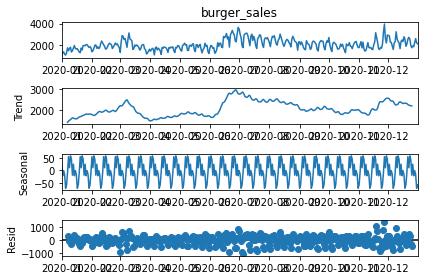

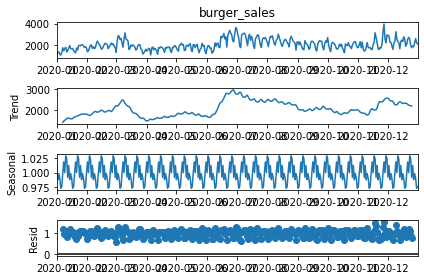

Date
2020-01-01        NaN
2020-01-02        NaN
2020-01-03        NaN
2020-01-04        NaN
2020-01-05        NaN
2020-01-06        NaN
2020-01-07   1427.500
2020-01-08   1485.833
2020-01-09   1525.000
2020-01-10   1558.333
2020-01-11   1603.750
2020-01-12   1638.333
2020-01-13   1631.667
2020-01-14   1607.917
2020-01-15   1602.083
2020-01-16   1593.750
2020-01-17   1608.750
2020-01-18   1654.167
2020-01-19   1682.917
2020-01-20   1695.417
2020-01-21   1713.750
2020-01-22   1740.000
2020-01-23   1755.833
2020-01-24   1774.583
2020-01-25   1805.000
2020-01-26   1824.583
2020-01-27   1817.917
2020-01-28   1814.583
2020-01-29   1822.500
2020-01-30   1825.417
2020-01-31   1817.500
2020-02-01   1799.583
2020-02-02   1776.667
2020-02-03   1755.417
2020-02-04   1765.000
2020-02-05   1802.500
2020-02-06   1843.333
2020-02-07   1890.000
2020-02-08   1935.000
2020-02-09   1948.750
2020-02-10   1931.667
2020-02-11   1911.250
2020-02-12   1919.583
2020-02-13   1948.333
2020-02-14   1978.750
2020-

In [ ]:
df_20 = main_df.loc["2020-01-01":"2020-12-31"]
decompose(df_20,'burger_sales',12,'additive')
decompose(df_20,'burger_sales',12,'multiplicative')

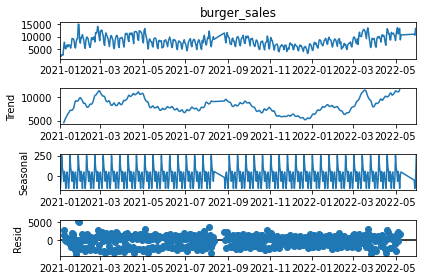

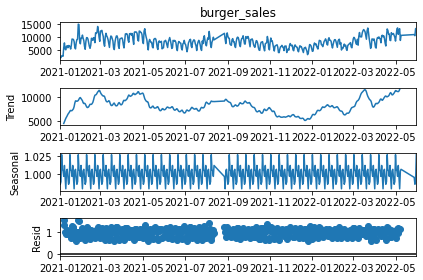

Date
2021-01-01         NaN
2021-01-02         NaN
2021-01-03         NaN
2021-01-04         NaN
2021-01-05         NaN
2021-01-06         NaN
2021-01-07    4557.083
2021-01-08    4910.417
2021-01-09    5287.917
2021-01-10    5621.250
2021-01-11    5870.000
2021-01-12    6147.083
2021-01-13    6455.000
2021-01-14    6647.500
2021-01-15    6857.500
2021-01-16    7139.583
2021-01-17    7251.667
2021-01-18    7183.750
2021-01-19    7213.750
2021-01-20    7386.667
2021-01-21    7581.250
2021-01-22    8037.500
2021-01-23    8777.083
2021-01-24    9218.750
2021-01-25    9200.833
2021-01-26    9145.000
2021-01-27    9185.417
2021-01-28    9307.500
2021-01-29    9553.750
2021-01-30    9830.000
2021-01-31    9902.917
2021-02-01    9693.333
2021-02-02    9507.500
2021-02-03    9260.417
2021-02-04    8841.250
2021-02-05    8673.333
2021-02-06    8731.250
2021-02-07    8618.333
2021-02-08    8324.583
2021-02-09    8003.750
2021-02-10    7843.750
2021-02-11    7875.417
2021-02-12    8003.333
2021-0

In [ ]:
df_21 = main_df.loc["2021-01-01":]
decompose(df_21,'burger_sales',12,'additive')
decompose(df_21,'burger_sales',12,'multiplicative')

In [ ]:
fig = px.line(main_df, y = 'burger_sales_detrend', title = 'Burger Sales Detrended'  )
fig.update_xaxes(rangeslider_visible=True)
fig.show()

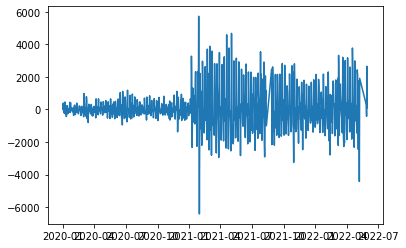

In [ ]:
plt.plot(main_df['burger_sales_detrend'])

Doing Min Max Scaling of detrended data 

In [ ]:
from sklearn.preprocessing import MinMaxScaler
dt = main_df['burger_sales_detrend'].array.reshape(-1,1)
scaler = MinMaxScaler()
main_df['burger_sales_detrend'] = scaler.fit_transform(dt)

Checking the Statinarity of all the Variables 

In [ ]:
def arima_by_channel(channel):
  
  prod = main_df[channel]
  print("Total Number of Rows:",prod.shape[0])
  print(f"Minimum Date: {min(prod.index)} and Maximum Date: {max(prod.index)}")
  print(f"Minimum Value: {min(prod)} and Maximum Value: {max(prod)}")
  print

  prod.plot()
  plt.show()

  #test statistics
  results = adfuller(prod)
  print(f'ADF statistics : {results[0]}')
  print(f'p-value : {results[1]}')
  print(f'Critical Values : {results[4]}')

  if ((results[1] >= 0.05) == True):
    return print(" Please make the data stationary first to proceed")
  else:
    print("Data is stationary!")
    train_size = int(len(prod) * 0.90)
    train, test = prod[0:train_size], prod[train_size:]
    print(f"Train Data Size: {train.shape[0]}  and Test Data Size: {test.shape[0]}")

    history = [x for x in train]
    predictions = list()

    for i in range(len(test)):
        model = sm.tsa.arima.ARIMA(history, order=(1,0,1))
        model_fit = model.fit()
        yhat = model_fit.forecast()
        predictions.append(yhat[0])
        obs = test[i]
        history.append(obs)

    rmse = np.sqrt(mean_squared_error(test, predictions))
    print(f"Mean of the data is {prod.mean()} and Standard Deviation: {prod.std()}")
    print(f'RMSE : {rmse}')
    
    # plot errors
    pyplot.plot(pd.DataFrame(predictions))
    pyplot.plot(pd.DataFrame(test.values), color='red')
    pyplot.show()

Channel: burger_sales
Total Number of Rows: 850
Minimum Date: 2020-01-01 00:00:00 and Maximum Date: 2022-05-31 00:00:00
Minimum Value: 950 and Maximum Value: 14880


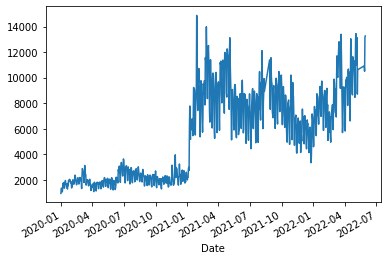

ADF statistics : -1.0126331175289467
p-value : 0.7486288199594897
Critical Values : {'1%': -3.438272329479064, '5%': -2.8650369467745573, '10%': -2.568632068251301}
 Please make the data stationary first to proceed
##################################################
##################################################
Channel: burger_sales_detrend
Total Number of Rows: 850
Minimum Date: 2020-01-01 00:00:00 and Maximum Date: 2022-05-31 00:00:00
Minimum Value: 0.0 and Maximum Value: 1.0


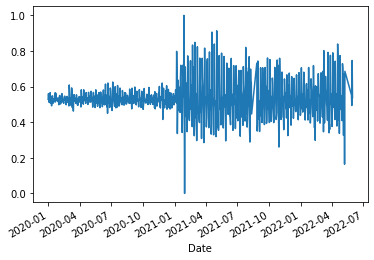

ADF statistics : -6.787505578288399
p-value : 2.411144056087827e-09
Critical Values : {'1%': -3.438272329479064, '5%': -2.8650369467745573, '10%': -2.568632068251301}
Data is stationary!
Train Data Size: 765  and Test Data Size: 85
Mean of the data is 0.5296367780418021 and Standard Deviation: 0.09511744329383907
RMSE : 0.1237558974727514


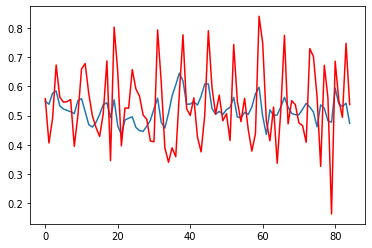

##################################################
##################################################
Channel: Daily_Investment
Total Number of Rows: 850
Minimum Date: 2020-01-01 00:00:00 and Maximum Date: 2022-05-31 00:00:00
Minimum Value: 2039.06734 and Maximum Value: 570236.24282


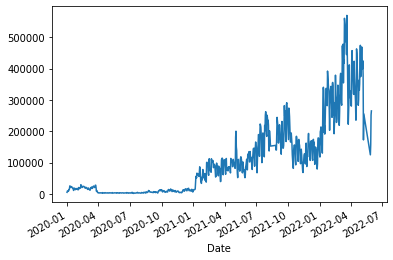

ADF statistics : -0.7468063447510997
p-value : 0.8342503931364535
Critical Values : {'1%': -3.438262743153934, '5%': -2.8650327208928976, '10%': -2.5686298171529347}
 Please make the data stationary first to proceed
##################################################
##################################################
Channel: Instagram_Cost
Total Number of Rows: 850
Minimum Date: 2020-01-01 00:00:00 and Maximum Date: 2022-05-31 00:00:00
Minimum Value: 0.0 and Maximum Value: 31764.5


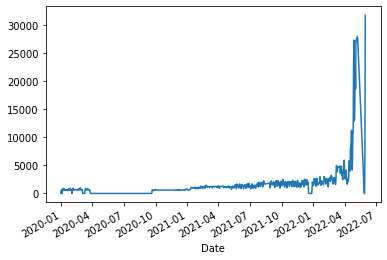

ADF statistics : -0.5908587211806637
p-value : 0.8730342315867043
Critical Values : {'1%': -3.438272329479064, '5%': -2.8650369467745573, '10%': -2.568632068251301}
 Please make the data stationary first to proceed
##################################################
##################################################
Channel: Bing_Cost
Total Number of Rows: 850
Minimum Date: 2020-01-01 00:00:00 and Maximum Date: 2022-05-31 00:00:00
Minimum Value: 0.0 and Maximum Value: 100594.5


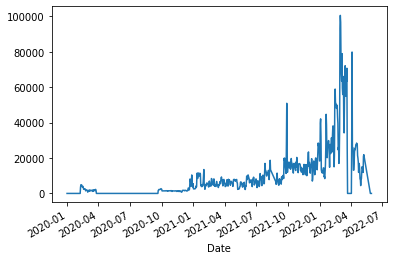

ADF statistics : -3.048824562193908
p-value : 0.03057958761158696
Critical Values : {'1%': -3.438262743153934, '5%': -2.8650327208928976, '10%': -2.5686298171529347}
Data is stationary!
Train Data Size: 765  and Test Data Size: 85
Mean of the data is 8811.259411764706 and Standard Deviation: 13523.92411496783
RMSE : 13857.240409972077


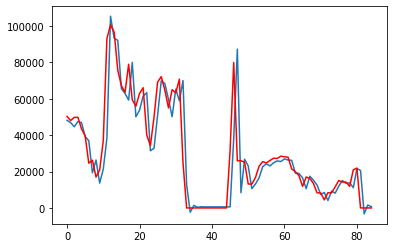

##################################################
##################################################
Channel: Facebook_Cost
Total Number of Rows: 850
Minimum Date: 2020-01-01 00:00:00 and Maximum Date: 2022-05-31 00:00:00
Minimum Value: 0.0 and Maximum Value: 220378.1


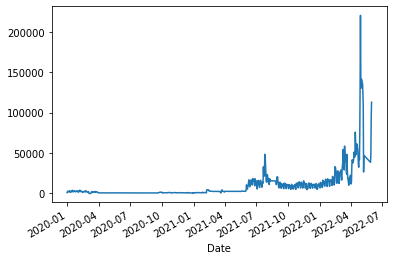

ADF statistics : 3.4696578245548513
p-value : 1.0
Critical Values : {'1%': -3.4382531800005944, '5%': -2.8650285052126057, '10%': -2.5686275714907825}
 Please make the data stationary first to proceed
##################################################
##################################################
Channel: Google_Cost
Total Number of Rows: 850
Minimum Date: 2020-01-01 00:00:00 and Maximum Date: 2022-05-31 00:00:00
Minimum Value: 1384.36734 and Maximum Value: 414996.44795


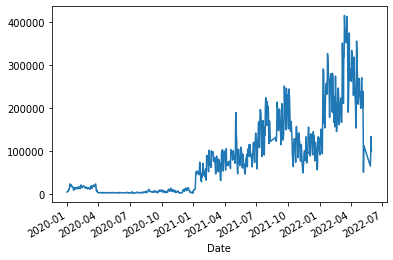

ADF statistics : -1.720885925604005
p-value : 0.4203848149292042
Critical Values : {'1%': -3.4382057088878644, '5%': -2.865007578546518, '10%': -2.5686164240381513}
 Please make the data stationary first to proceed
##################################################
##################################################
Channel: Pinterest_Cost
Total Number of Rows: 850
Minimum Date: 2020-01-01 00:00:00 and Maximum Date: 2022-05-31 00:00:00
Minimum Value: 0.0 and Maximum Value: 25803.1


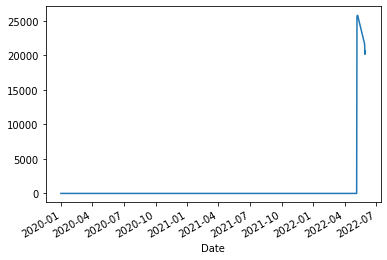

ADF statistics : -1.2152354987439065
p-value : 0.6670076877217159
Critical Values : {'1%': -3.4381032536542913, '5%': -2.8649624121419746, '10%': -2.5685923644574107}
 Please make the data stationary first to proceed
##################################################
##################################################
Channel: Tiktok Cost
Total Number of Rows: 850
Minimum Date: 2020-01-01 00:00:00 and Maximum Date: 2022-05-31 00:00:00
Minimum Value: 0.0 and Maximum Value: 37641.9


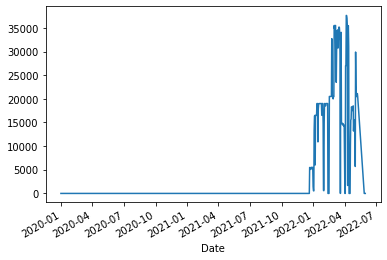

ADF statistics : -1.3727442695799263
p-value : 0.5952708827671233
Critical Values : {'1%': -3.438262743153934, '5%': -2.8650327208928976, '10%': -2.5686298171529347}
 Please make the data stationary first to proceed
##################################################
##################################################


In [ ]:
#for individual channels
for i in list(main_df.columns[:-1]):
  print(f"Channel: {i}")
  arima_by_channel(i)
  print("#"*50)
  print("#"*50)
    

### Correlation Heatmap

Heat Map for entire data

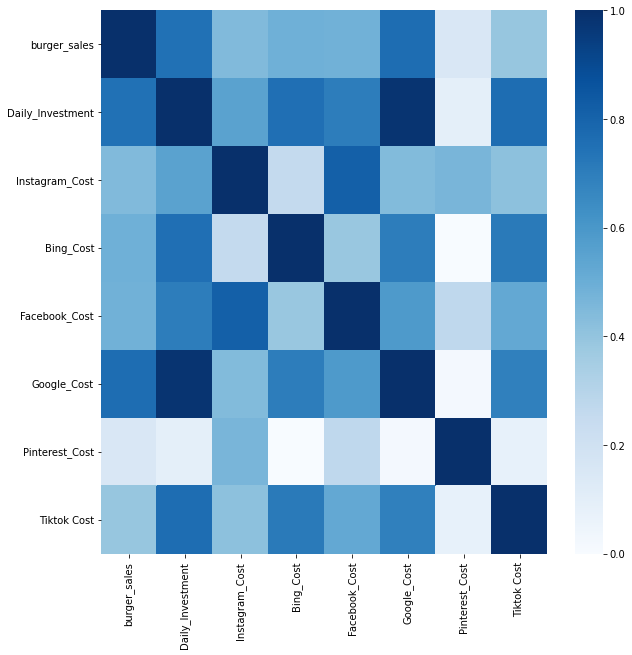

In [ ]:
corr = main_df[['burger_sales', 'Daily_Investment','Instagram_Cost', 'Bing_Cost', 'Facebook_Cost', 'Google_Cost', 'Pinterest_Cost', 'Tiktok Cost']].corr()
plt.rcParams['figure.figsize'] = (10, 10)
sns.heatmap(corr, xticklabels = corr.columns.values, yticklabels = corr.columns.values, cmap = "Blues")
plt.show()

Heat Map shows that the Google_Cost has the highest effect on the Burger Sales followed by Facebook, Bing and INstagram 

Finding the Correlation among the data of 2020-2021

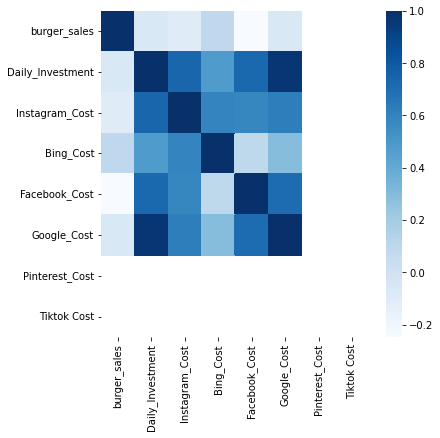

In [ ]:
corr = df_20[['burger_sales', 'Daily_Investment','Instagram_Cost', 'Bing_Cost', 'Facebook_Cost', 'Google_Cost', 'Pinterest_Cost', 'Tiktok Cost']].corr()
plt.rcParams['figure.figsize'] = (6, 6)
sns.heatmap(corr, xticklabels = corr.columns.values, yticklabels = corr.columns.values, cmap = "Blues")
plt.show()

This shows that the burger sales had little or no corrleation with the marketing channels in 2020

Finding the Correlation among the data of 2021 onwards.

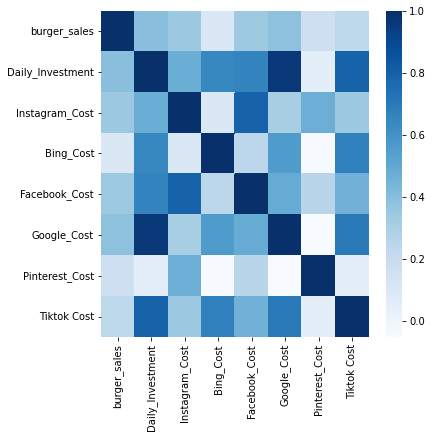

In [ ]:
corr = df_21[['burger_sales', 'Daily_Investment','Instagram_Cost', 'Bing_Cost', 'Facebook_Cost', 'Google_Cost', 'Pinterest_Cost', 'Tiktok Cost']].corr()
plt.rcParams['figure.figsize'] = (6, 6)
sns.heatmap(corr, xticklabels = corr.columns.values, yticklabels = corr.columns.values, cmap = "Blues")
plt.show()

Where as 2021 onwards there had been slight correlation among the marketing variables 
 

#### Checking the Multi Colinearity 

In [ ]:
# Lets check for Multicollinearity over entire data

checkVIF(main_df,['Instagram_Cost', 'Bing_Cost','Google_Cost', 'Pinterest_Cost','Tiktok Cost'])

feature   VIF
0  Instagram_Cost 2.163
1       Bing_Cost 3.575
2     Google_Cost 3.786
3  Pinterest_Cost 1.367
4     Tiktok Cost 2.623

There doesn't seem to be any sort of multi-colinearity among the variables.

##MMX ##########################


### Reading the Raw data

In [ ]:
data = pd.read_csv(
   'Burger_Sales.csv',
    parse_dates=['Date'],
    index_col='Date')
data.tail()

burger_sales  Instagram_Cost  Bing_Cost  Facebook_Cost   Google_Cost  Pinterest_Cost  Tiktok Cost
Date                                                                                                         
2022-05-09         10630         27689.7    21901.7        47154.0  112787.84487         25793.2      20479.5
2022-05-28         10930             0.0        0.0        38461.0   64788.29081         21939.2          0.0
2022-05-29         10510             0.0        0.0        45635.0   89638.52679         21673.6          0.0
2022-05-30         13160          7424.3        0.0        91366.7  133683.23351         20171.6          0.0
2022-05-31         13270         31764.5        0.0       112900.9  100072.20142         20679.2          0.0

In [ ]:
# we donot do the traditional k fold split, instead we used the time_series_split 
# which is more suitable for the time series data at hand. In this successive training sets are
# the supersets of those that come before them 

# we find CV scores using time series split which tells us the accuracy of the model 
# on each split which we can further avg out. these are -ve MSE values
X = data.drop(columns=['burger_sales'])
y = data['burger_sales']

lr = LinearRegression()
print('Cross Val Scores :', cross_val_score(lr, X, y, cv=TimeSeriesSplit()).mean())

Cross Val Scores : -17.095963617122464


In [ ]:
# we use LR which is a good additive model
lr.fit(X, y) # refit the model with the complete dataset
print('Coefficients:', lr.coef_)
print('Intercept:', lr.intercept_)

Coefficients: [ 0.19549557  0.01891229 -0.01357207  0.03457423  0.15542769 -0.14426633]
Intercept: 2729.6714837391437


In [ ]:
# we plug in a row from the dataset into the LR model
print(lr.predict(([[27689.7,21901.7,47154.0,112787.84487,25793.2,20479.5]])))


[12871.14679717]


In [ ]:
# the answer is not exactly the same so we adjust the coeff 
print(lr.predict(([[27689.7*0.19549557,21901.7*0.01891229,47154.0*-0.01357207,112787.84487*0.03457423,25793.2*0.15542769,20479.5*-0.14426633]])))


[4988.61558811]


In [ ]:
# Now, the contributions sum up to the model prediction 4988.61, 
# which is not the true target of 10630, so let us just multiply 
# the contributions and baseline by a correction factor of 
# correction_factor = 10630 / 4988.61 ≈ 2.13

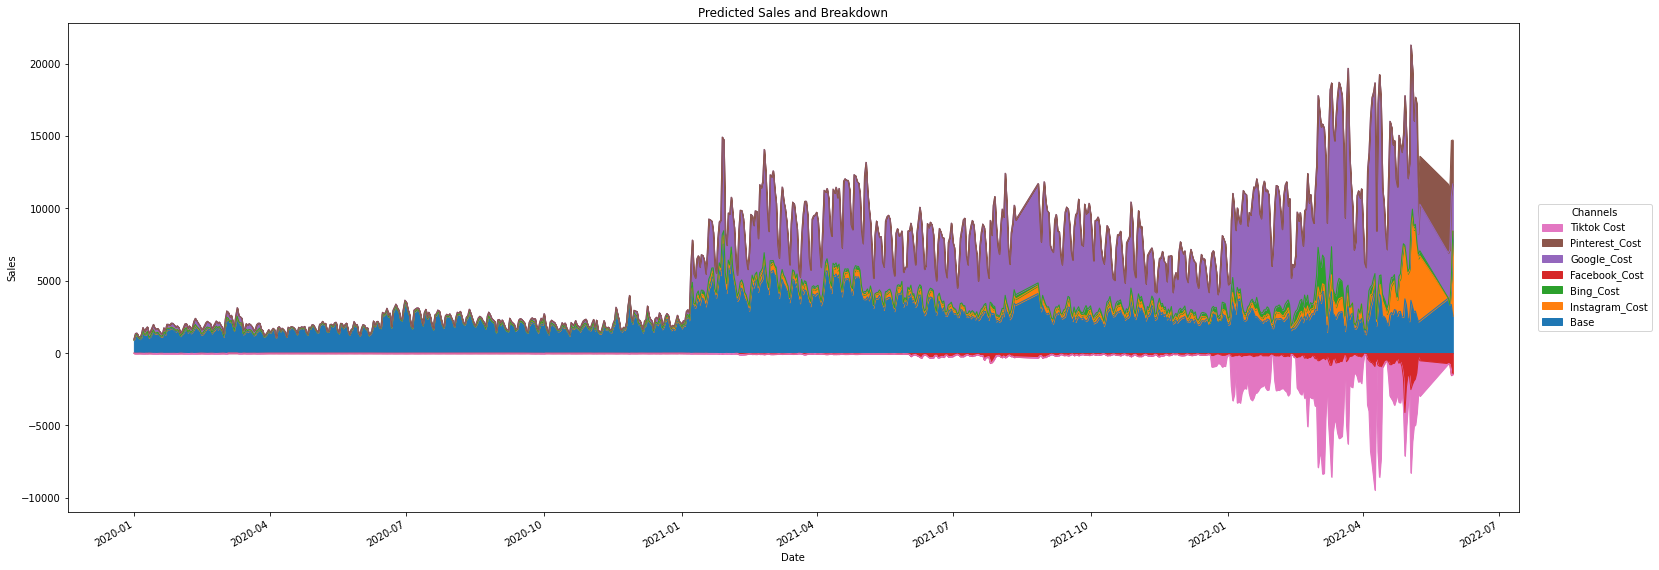

In [ ]:
weights = pd.Series(
    lr.coef_,
    index=X.columns
)
base = lr.intercept_
unadj_contributions = X.mul(weights).assign(Base=base)
adj_contributions = (unadj_contributions
                     .div(unadj_contributions.sum(axis=1), axis=0)
                     .mul(y, axis=0)
                    ) # contains all contributions for each day
ax = (adj_contributions[['Base', 'Instagram_Cost', 'Bing_Cost', 'Facebook_Cost', 'Google_Cost', 'Pinterest_Cost', 'Tiktok Cost']]
      .plot.area(
          figsize=(26, 10),
          linewidth=1,
          title='Predicted Sales and Breakdown',
          ylabel='Sales',
          xlabel='Date')
     )
handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles[::-1], labels[::-1],
    title='Channels', loc="center left",
    bbox_to_anchor=(1.01, 0.5)
)

In [ ]:
unadj_contributions.head()

Instagram_Cost  Bing_Cost  Facebook_Cost  Google_Cost  Pinterest_Cost  Tiktok Cost         Base
Date                                                                                                       
2020-01-01        0.000000        0.0     -14.129879   153.765414             0.0         -0.0  2729.671484
2020-01-02      113.876168        0.0     -35.246658   226.844957             0.0         -0.0  2729.671484
2020-01-03      107.815806        0.0     -35.015933   224.742844             0.0         -0.0  2729.671484
2020-01-04        0.000000        0.0     -30.476076   224.718642             0.0         -0.0  2729.671484
2020-01-05      105.567607        0.0     -23.766046   224.701355             0.0         -0.0  2729.671484

In [ ]:
adj_contributions.head()

Instagram_Cost  Bing_Cost  Facebook_Cost  Google_Cost  Pinterest_Cost  Tiktok Cost         Base
Date                                                                                                       
2020-01-01        0.000000        0.0      -4.678267    50.910252             0.0         -0.0   903.768015
2020-01-02       50.275693        0.0     -15.561203   100.150782             0.0         -0.0  1205.134727
2020-01-03       48.793261        0.0     -15.846856   101.709914             0.0         -0.0  1235.343681
2020-01-04        0.000000        0.0     -12.090728    89.152287             0.0         -0.0  1082.938441
2020-01-05       37.203838        0.0      -8.375563    79.188616             0.0         -0.0   961.983109

In [ ]:
temp = adj_contributions[['Base', 'Instagram_Cost', 'Bing_Cost', 'Facebook_Cost', 'Google_Cost', 'Pinterest_Cost', 'Tiktok Cost']]

In [ ]:
temp.head()

Base  Instagram_Cost  Bing_Cost  Facebook_Cost  Google_Cost  Pinterest_Cost  Tiktok Cost
Date                                                                                                       
2020-01-01   903.768015        0.000000        0.0      -4.678267    50.910252             0.0         -0.0
2020-01-02  1205.134727       50.275693        0.0     -15.561203   100.150782             0.0         -0.0
2020-01-03  1235.343681       48.793261        0.0     -15.846856   101.709914             0.0         -0.0
2020-01-04  1082.938441        0.000000        0.0     -12.090728    89.152287             0.0         -0.0
2020-01-05   961.983109       37.203838        0.0      -8.375563    79.188616             0.0         -0.0

Plotting the daily sales

In [ ]:
fig = px.line(temp, x =temp.index, y = temp.columns, title = 'Predicted Sales and Breakdown' )
fig.update_yaxes(title = 'Burger Sales in thousands')
fig.update_xaxes(rangeslider_visible=True)
fig.show()

# Computing the Return on Investment (ROI)

1. We assume that the more money you spend on advertising, the higher your sales get. However, the increase gets weaker the more we spend. For example, increasing the TV spends from 0 € to 100,000 € increases our sales a lot, but increasing it from 100,000 € to 100,100,000 € does not do that much anymore. This is called a saturation effect or the effect of diminishing returns.

2. If you spend money on advertising week T, often people will not immediately buy your product, but a few (let us say x) weeks later. This is because the product might be expensive, and people want to think about it carefully or compare it to similar products from other companies. Whatever the reason might be, the sale in week T + x is partially caused by the advertising you played in week T, so it should also get some credits. This is called the carry-over or lagged effect.



In [ ]:
def roi_variables(col):
    Channel = []
    ROI = []
    for i in col:
        sales_from = adj_contributions[i].sum()
        spendings_on = data[i].sum()
        Roi = i +'_ROI'
        Roi_val = (sales_from / spendings_on)*100
        Channel.append(Roi)
        ROI.append(Roi_val)
        df = pd.DataFrame(list(zip(Channel, ROI)), columns =['Channel', 'ROI_%'])
    return df

In [ ]:
X.columns

Index(['Instagram_Cost', 'Bing_Cost', 'Facebook_Cost', 'Google_Cost', 'Pinterest_Cost', 'Tiktok Cost'], dtype='object')

In [ ]:
roi_df = roi_variables(X.columns)
roi_df
roi_df.to_csv('roi_df.csv')

In [ ]:
ls -l

total 52
-rw-r--r-- 1 root root 43275 Mar 13 10:17 Burger_Sales.csv
-rw-r--r-- 1 root root   245 Mar 13 10:18 roi_df.csv
drwxr-xr-x 1 root root  4096 Mar  9 18:58 sample_data/


In [ ]:
adj_contributions.describe()

Instagram_Cost    Bing_Cost  Facebook_Cost   Google_Cost  Pinterest_Cost  Tiktok Cost         Base
count      850.000000   850.000000     850.000000    850.000000      850.000000   850.000000   850.000000
mean       307.509257   173.131052    -129.978339   3005.613914       30.529069  -442.062696  2607.622449
std        627.820393   274.531321     288.044171   3128.813384      338.982537  1277.461026  1057.003981
min          0.000000     0.000000   -4105.763390     31.808863        0.000000 -8529.517692   903.768015
25%         51.664699     0.000000    -144.897145    150.369181        0.000000     0.000000  1834.721461
50%        206.107560   102.011751     -46.728802   2505.548082        0.000000    -0.000000  2371.203334
75%        369.120765   239.666486      -7.774269   4985.664602        0.000000    -0.000000  3015.923046
max       6358.533065  2735.459873      -0.000000  14976.073689     4743.262765    -0.000000  7549.909722

####Creating a Saturation Effect

We want to create a transformation (=mathematical function) with the following properties:

1. If the spendings are 0, the saturated spendings are also 0.
2. The transformation is monotonically increasing, i.e. the higher the input spendings, the higher the saturated output spendings.
3. The saturated values do not grow to infinity. Instead, they are upper bounded by some number, let us say 1.
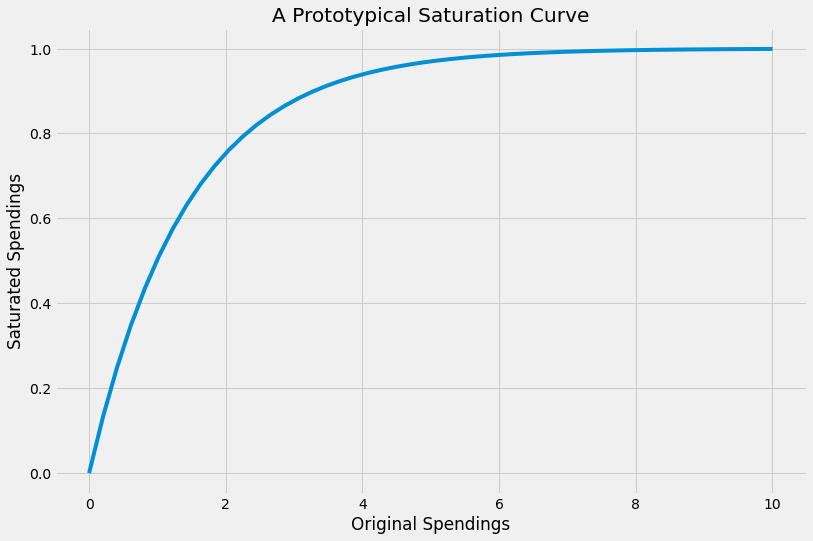

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted, check_array
class ExponentialSaturation(BaseEstimator, TransformerMixin):
    def __init__(self, a=1.):
        self.a = a
        
    def fit(self, X, y=None):
        X = check_array(X)
        self._check_n_features(X, reset=True) # from BaseEstimator
        return self
    def transform(self, X):
        check_is_fitted(self)
        X = check_array(X)
        self._check_n_features(X, reset=False) # from BaseEstimator
        return 1 - np.exp(-self.a*X)

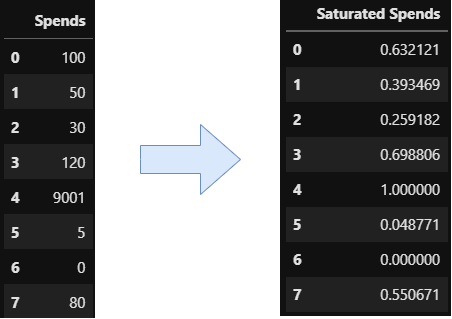

#### Creating a Carry-Over Effect

We are given a series of spendings over time such as

(16, 0, 0, 0, 0, 4, 8, 0, 0, 0),

meaning that we spent 16 in the first week, then we spent nothing from week 2 to 5, then we spent 4 in week 6, etc.

We now want that spendings in one week to get partially carried over to the next weeks in an exponential fashion. This means: In week 1 there is a spend of 16. Then we carry over 50%, meaning

*   0.5 * 16 = 8 to week 2
*   0.5² * 16 = 4 to week 3
*   0.5³ * 16 = 2 to week 4

This introduces two hyperparameters: the strength (how much gets carried over?) and the length (how long does it get carried over?) of the carry-over effect. If we use a strength of 50% and a length of 2, the spending sequence from above becomes

(16, 8, 4, 0, 0, 4, 10, 5, 2, 0).

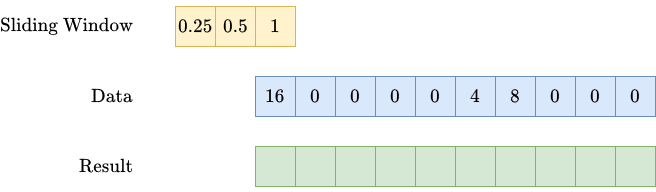

In [ ]:

from scipy.signal import convolve2d
import numpy as np
class ExponentialCarryover(BaseEstimator, TransformerMixin):
    def __init__(self, strength=0.5, length=1):
        self.strength = strength
        self.length = length
    def fit(self, X, y=None):
        X = check_array(X)
        self._check_n_features(X, reset=True)
        self.sliding_window_ = (
            self.strength ** np.arange(self.length + 1)
        ).reshape(-1, 1)
        return self
    def transform(self, X: np.ndarray):
        check_is_fitted(self)
        X = check_array(X)
        self._check_n_features(X, reset=False)
        convolution = convolve2d(X, self.sliding_window_)
        if self.length > 0:
            convolution = convolution[: -self.length]
        return convolution

Creating PIpeline and Transformes

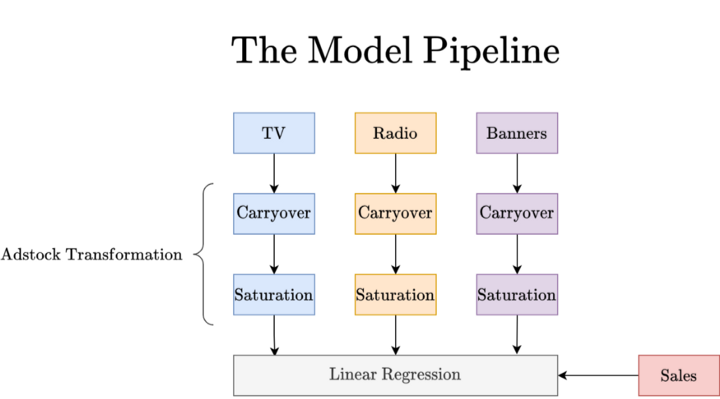

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
adstock = ColumnTransformer(
    [
     ('Instagram_pipe', Pipeline([
                           ('carryover', ExponentialCarryover()),
                           ('saturation', ExponentialSaturation())
     ]), ['Instagram_Cost']),
     ('Bing_pipe', Pipeline([
                           ('carryover', ExponentialCarryover()),
                           ('saturation', ExponentialSaturation())
     ]), ['Bing_Cost']),
     ('Facebook_pipe', Pipeline([
                           ('carryover', ExponentialCarryover()),
                           ('saturation', ExponentialSaturation())
     ]), ['Facebook_Cost']),
        ('Google_pipe', Pipeline([
                           ('carryover', ExponentialCarryover()),
                           ('saturation', ExponentialSaturation())
     ]), ['Google_Cost']),
        ('Pinterest_pipe', Pipeline([
                           ('carryover', ExponentialCarryover()),
                           ('saturation', ExponentialSaturation())
     ]), ['Pinterest_Cost']),
        ('TiktoK_pipe', Pipeline([
                           ('carryover', ExponentialCarryover()),
                           ('saturation', ExponentialSaturation())
     ]), ['Tiktok Cost']),
    ],
    remainder='passthrough'
)
model = Pipeline([
                  ('adstock', adstock),
                  ('regression', LinearRegression())
])

In [ ]:
X = data.drop(columns=['burger_sales'])
y = data['burger_sales']
model.fit(X, y)
print(cross_val_score(model, X, y, cv=TimeSeriesSplit()).mean())

-2.2545379119900106


### Installing the Optuna Library

In [ ]:
pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 KB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 8.2 MB/s eta 0:00:00


### Optimizing the LR model using the Optuna Search CV

In [ ]:
import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler

from optuna.integration import OptunaSearchCV
from optuna.distributions import FloatDistribution, IntDistribution
tuned_model = OptunaSearchCV(estimator=model,
                             param_distributions = {
                                 'adstock__Instagram_pipe__carryover__strength': FloatDistribution(high=1.0, log=False, low=0.0, step=None),
                                 'adstock__Instagram_pipe__carryover__length':IntDistribution(high=6, log=False, low=0, step=1),
                                 'adstock__Instagram_pipe__saturation__a': FloatDistribution(high=0.01, log=False, low=0.0, step=None),
                                 'adstock__Bing_pipe__carryover__strength': FloatDistribution(high=1.0, log=False, low=0.0, step=None),
                                 'adstock__Bing_pipe__carryover__length': IntDistribution(high=6, log=False, low=0, step=1),
                                 'adstock__Bing_pipe__saturation__a': FloatDistribution(high=0.01, log=False, low=0.0, step=None),
                                 'adstock__Facebook_pipe__carryover__strength': FloatDistribution(high=1.0, log=False, low=0.0, step=None),
                                 'adstock__Facebook_pipe__carryover__length': IntDistribution(high=6, log=False, low=0, step=1),
                                 'adstock__Facebook_pipe__saturation__a': FloatDistribution(high=0.01, log=False, low=0.0, step=None),
                                 'adstock__Google_pipe__carryover__strength': FloatDistribution(high=1.0, log=False, low=0.0, step=None),
                                 'adstock__Google_pipe__carryover__length': IntDistribution(high=6, log=False, low=0, step=1),
                                 'adstock__Google_pipe__saturation__a': FloatDistribution(high=0.01, log=False, low=0.0, step=None),
                                 'adstock__Pinterest_pipe__carryover__strength': FloatDistribution(high=1.0, log=False, low=0.0, step=None),
                                 'adstock__Pinterest_pipe__carryover__length':IntDistribution(high=6, log=False, low=0, step=1),
                                 'adstock__Pinterest_pipe__saturation__a': FloatDistribution(high=0.01, log=False, low=0.0, step=None),
                                 'adstock__TiktoK_pipe__carryover__strength': FloatDistribution(high=1.0, log=False, low=0.0, step=None),
                                 'adstock__TiktoK_pipe__carryover__length': IntDistribution(high=6, log=False, low=0, step=1),
                                 'adstock__TiktoK_pipe__saturation__a': FloatDistribution(high=0.01, log=False, low=0.0, step=None),
                             },
                             n_trials=1000,
                             cv=TimeSeriesSplit(),
                             random_state=0)

In [ ]:
print(cross_val_score(tuned_model, X, y, cv=TimeSeriesSplit()).mean())


[I 2023-03-13 10:18:32,890] A new study created in memory with name: no-name-3c1989b5-902d-488e-bac2-f81dad4fef5b
[I 2023-03-13 10:18:33,088] Trial 0 finished with value: -2903881485.644014 and parameters: {'adstock__Instagram_pipe__carryover__strength': 0.4860473230215504, 'adstock__Instagram_pipe__carryover__length': 4, 'adstock__Instagram_pipe__saturation__a': 0.009855760506615989, 'adstock__Bing_pipe__carryover__strength': 0.1955964101622225, 'adstock__Bing_pipe__carryover__length': 4, 'adstock__Bing_pipe__saturation__a': 0.00980582177099305, 'adstock__Facebook_pipe__carryover__strength': 0.18048029738995275, 'adstock__Facebook_pipe__carryover__length': 4, 'adstock__Facebook_pipe__saturation__a': 0.008463095456331128, 'adstock__Google_pipe__carryover__strength': 0.7967092952533198, 'adstock__Google_pipe__carryover__length': 6, 'adstock__Google_pipe__saturation__a': 0.00517502161880338, 'adstock__Pinterest_pipe__carryover__strength': 0.04182737713424278, 'adstock__Pinterest_pipe__ca

KeyboardInterrupt: ignored

Fitting the model

In [ ]:
tuned_model.fit(X, y)

print(tuned_model.best_params_)
print(tuned_model.best_estimator_.named_steps['regression'].coef_)
print(tuned_model.best_estimator_.named_steps['regression'].intercept_)


[I 2023-03-13 10:19:06,024] A new study created in memory with name: no-name-d477f22a-7d58-4d7d-9e31-1dd17a7376df
[I 2023-03-13 10:19:06,468] Trial 0 finished with value: -251.911648317412 and parameters: {'adstock__Instagram_pipe__carryover__strength': 0.4860473230215504, 'adstock__Instagram_pipe__carryover__length': 4, 'adstock__Instagram_pipe__saturation__a': 0.009855760506615989, 'adstock__Bing_pipe__carryover__strength': 0.1955964101622225, 'adstock__Bing_pipe__carryover__length': 4, 'adstock__Bing_pipe__saturation__a': 0.00980582177099305, 'adstock__Facebook_pipe__carryover__strength': 0.18048029738995275, 'adstock__Facebook_pipe__carryover__length': 4, 'adstock__Facebook_pipe__saturation__a': 0.008463095456331128, 'adstock__Google_pipe__carryover__strength': 0.7967092952533198, 'adstock__Google_pipe__carryover__length': 6, 'adstock__Google_pipe__saturation__a': 0.00517502161880338, 'adstock__Pinterest_pipe__carryover__strength': 0.04182737713424278, 'adstock__Pinterest_pipe__car

{'adstock__Instagram_pipe__carryover__strength': 0.7533143192741102, 'adstock__Instagram_pipe__carryover__length': 0, 'adstock__Instagram_pipe__saturation__a': 0.00045275971820584924, 'adstock__Bing_pipe__carryover__strength': 0.3542163068714077, 'adstock__Bing_pipe__carryover__length': 0, 'adstock__Bing_pipe__saturation__a': 0.00044797656507278587, 'adstock__Facebook_pipe__carryover__strength': 0.9274868854481771, 'adstock__Facebook_pipe__carryover__length': 2, 'adstock__Facebook_pipe__saturation__a': 0.0007370530574459574, 'adstock__Google_pipe__carryover__strength': 0.5998896328099816, 'adstock__Google_pipe__carryover__length': 5, 'adstock__Google_pipe__saturation__a': 0.009790684511801808, 'adstock__Pinterest_pipe__carryover__strength': 0.23512567079932245, 'adstock__Pinterest_pipe__carryover__length': 0, 'adstock__Pinterest_pipe__saturation__a': 0.009095080980756424, 'adstock__TiktoK_pipe__carryover__strength': 0.5470825917776725, 'adstock__TiktoK_pipe__carryover__length': 0, 'ads

In [ ]:
best_parms = tuned_model.best_params_
best_parms

{'adstock__Instagram_pipe__carryover__strength': 0.5506515265773121,
 'adstock__Instagram_pipe__carryover__length': 0,
 'adstock__Instagram_pipe__saturation__a': 0.0002923242926607156,
 'adstock__Bing_pipe__carryover__strength': 0.7705469973204172,
 'adstock__Bing_pipe__carryover__length': 0,
 'adstock__Bing_pipe__saturation__a': 0.00031799610991701014,
 'adstock__Facebook_pipe__carryover__strength': 0.5430552453213194,
 'adstock__Facebook_pipe__carryover__length': 3,
 'adstock__Facebook_pipe__saturation__a': 0.009411030303202108,
 'adstock__Google_pipe__carryover__strength': 0.6155694185667041,
 'adstock__Google_pipe__carryover__length': 1,
 'adstock__Google_pipe__saturation__a': 0.009833595565464393,
 'adstock__Pinterest_pipe__carryover__strength': 0.5722092740475561,
 'adstock__Pinterest_pipe__carryover__length': 1,
 'adstock__Pinterest_pipe__saturation__a': 0.004633060060227545,
 'adstock__TiktoK_pipe__carryover__strength': 0.7982902018395994,
 'adstock__TiktoK_pipe__carryover__len

In [ ]:
print(tuned_model.best_estimator_.named_steps['regression'].coef_)
print(tuned_model.best_estimator_.named_steps['regression'].intercept_)

[ 7.46157887e+03  3.77994847e+03  5.22484241e+02 -1.22339512e+13
  3.45877184e+03 -6.09482997e+02]
12233951241043.312


####We calculate the contributions of each channel to the sales for each day. 

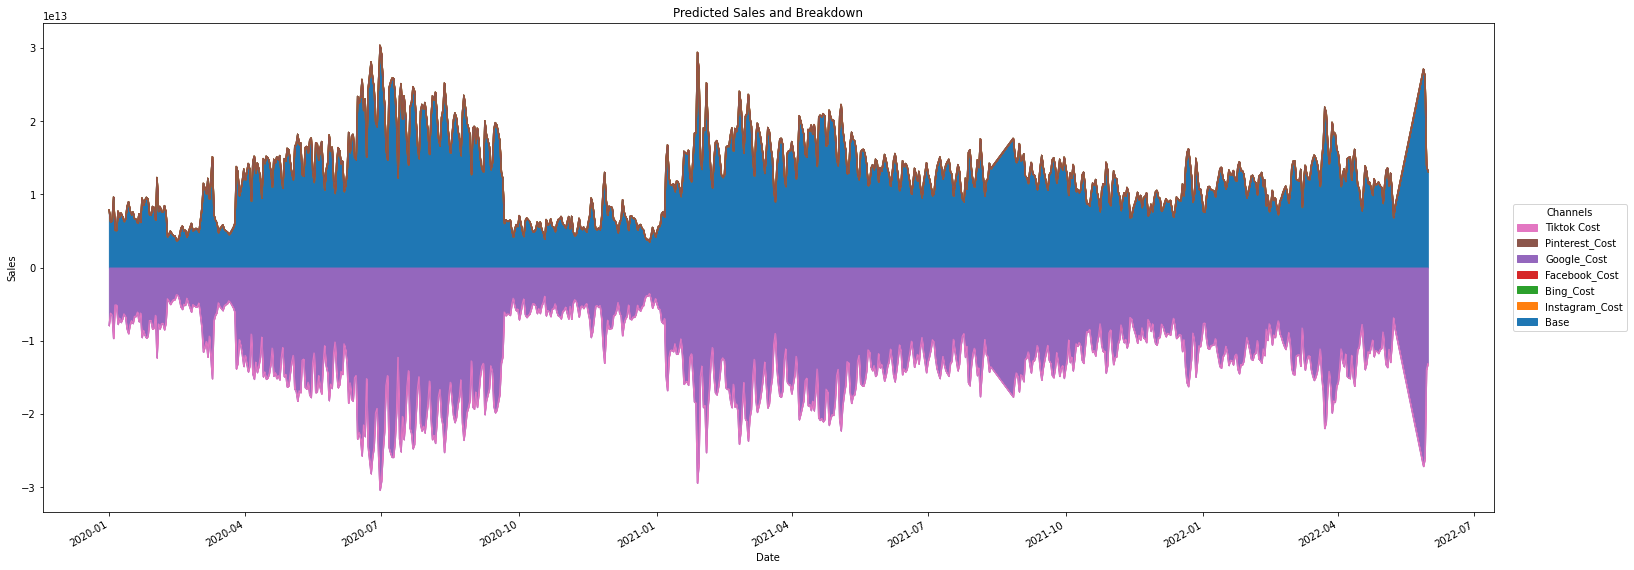

In [ ]:
adstock_data = pd.DataFrame(
    tuned_model.best_estimator_.named_steps['adstock'].transform(X),
    columns=X.columns,
    index=X.index
)
weights = pd.Series(
    tuned_model.best_estimator_.named_steps['regression'].coef_,
    index=X.columns
)
base = tuned_model.best_estimator_.named_steps['regression'].intercept_
unadj_contributions = adstock_data.mul(weights).assign(Base=base)
adj_contributions = (unadj_contributions                        # Calculating the error value and multiplying it with the unadjusted value
                     .div(unadj_contributions.sum(axis=1), axis=0)
                     .mul(y, axis=0)
                    )
ax = (adj_contributions[['Base', 'Instagram_Cost', 'Bing_Cost', 'Facebook_Cost', 'Google_Cost', 'Pinterest_Cost', 'Tiktok Cost']]
      .plot.area(
          figsize=(26, 10),
          linewidth=1,
          title='Predicted Sales and Breakdown',
          ylabel='Sales',
          xlabel='Date'

      )
     )
    
handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles[::-1], labels[::-1],
    title='Channels', loc="center left",
    bbox_to_anchor=(1.01, 0.5)
)

temp = adj_contributions[['Base', 'Instagram_Cost', 'Bing_Cost', 'Facebook_Cost', 'Google_Cost', 'Pinterest_Cost', 'Tiktok Cost']]
fig = px.line(temp, x =temp.index, y = temp.columns, title = 'Predicted Sales and Breakdown' )
fig.update_yaxes(title = 'Burger Sales in thousands')
fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(legend_title=" Channel Sales ") 

fig.show()


####Compared to the old picture, the baseline is not so wiggly anymore because the model can explain the sales better with the given channel spendings. 

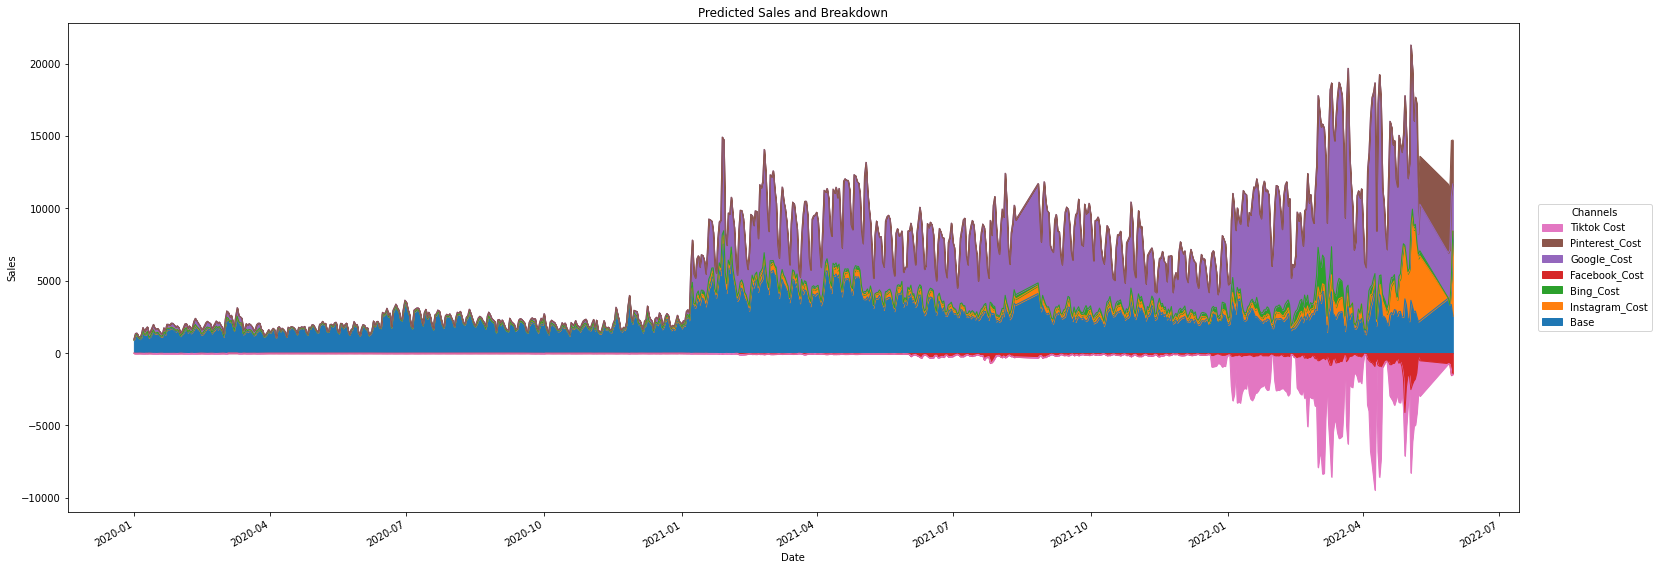

Calculating the ROI based on the hypertuned model 

In [ ]:
#Calling the ROI function
roi_variables(X.columns)

Channel         ROI_%
0  Instagram_Cost_ROI  1.258134e+02
1       Bing_Cost_ROI  2.450368e+01
2   Facebook_Cost_ROI  5.739601e+00
3     Google_Cost_ROI -1.523074e+10
4  Pinterest_Cost_ROI  1.851695e+01
5     Tiktok Cost_ROI -3.151660e+00

In [ ]:
#Predicted Daily sales contribution of individual Channels 
temp.head()

Base  Instagram_Cost  Bing_Cost  Facebook_Cost  \
Date                                                                
2020-01-01  1590.193227        0.000000       -0.0   -1094.965268   
2020-01-02  3135.829220     1232.431908       -0.0   -4598.272305   
2020-01-03  2873.231708     1075.935423       -0.0   -4192.653737   
2020-01-04  4341.183146        0.000000       -0.0   -5699.668679   
2020-01-05  1223.267485      449.582102       -0.0   -1316.544858   

            Google_Cost  Pinterest_Cost  Tiktok Cost  
Date                                                  
2020-01-01   454.772041             0.0         -0.0  
2020-01-02  1570.011177             0.0         -0.0  
2020-01-03  1613.486606             0.0         -0.0  
2020-01-04  2518.485533             0.0         -0.0  
2020-01-05   713.695272             0.0         -0.0

In [ ]:
temp['net_sales'] = temp.sum(axis=1) # Doing the sum of all the rows to validate if the earlier sales and predicted sales figues allign
temp.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Base  Instagram_Cost  Bing_Cost  Facebook_Cost  \
Date                                                                
2020-01-01  1590.193227        0.000000       -0.0   -1094.965268   
2020-01-02  3135.829220     1232.431908       -0.0   -4598.272305   
2020-01-03  2873.231708     1075.935423       -0.0   -4192.653737   
2020-01-04  4341.183146        0.000000       -0.0   -5699.668679   
2020-01-05  1223.267485      449.582102       -0.0   -1316.544858   

            Google_Cost  Pinterest_Cost  Tiktok Cost  net_sales  
Date                                                             
2020-01-01   454.772041             0.0         -0.0      950.0  
2020-01-02  1570.011177             0.0         -0.0     1340.0  
2020-01-03  1613.486606             0.0         -0.0     1370.0  
2020-01-04  2518.485533             0.0         -0.0     1160.0  
2020-01-05   713.695272             0.0         -0.0     1070.0

In [ ]:
y.head() # Original Daily Sales figure of burgers

Date
2020-01-01     950
2020-01-02    1340
2020-01-03    1370
2020-01-04    1160
2020-01-05    1070
Name: burger_sales, dtype: int64

In [ ]:
# The hypertuned parameters for Carryover, Saturation
best_parms 

{'adstock__Instagram_pipe__carryover__strength': 0.7789187510062395,
 'adstock__Instagram_pipe__carryover__length': 0,
 'adstock__Instagram_pipe__saturation__a': 0.000426504253106935,
 'adstock__Bing_pipe__carryover__strength': 0.8808409964455327,
 'adstock__Bing_pipe__carryover__length': 5,
 'adstock__Bing_pipe__saturation__a': 0.0007329181129720743,
 'adstock__Facebook_pipe__carryover__strength': 0.9672990471106234,
 'adstock__Facebook_pipe__carryover__length': 0,
 'adstock__Facebook_pipe__saturation__a': 0.00021761572654943438,
 'adstock__Google_pipe__carryover__strength': 0.30800397943397145,
 'adstock__Google_pipe__carryover__length': 3,
 'adstock__Google_pipe__saturation__a': 1.0708360949945991e-05,
 'adstock__Pinterest_pipe__carryover__strength': 0.4021679890244784,
 'adstock__Pinterest_pipe__carryover__length': 6,
 'adstock__Pinterest_pipe__saturation__a': 0.004462303077980497,
 'adstock__TiktoK_pipe__carryover__strength': 0.9114408728470077,
 'adstock__TiktoK_pipe__carryover__

Plugging the hypertuned Carryover values

In [ ]:
adstock = ColumnTransformer(
    [
     ('Instagram_pipe', Pipeline([
                           ('carryover', ExponentialCarryover(0.7789187510062395,0)),
                           #('saturation', ExponentialSaturation(0.000426504253106935))
     ]), ['Instagram_Cost']),
     ('Bing_pipe', Pipeline([
                           ('carryover', ExponentialCarryover(0.8808409964455327,5)),
                           #('saturation', ExponentialSaturation(0.0007329181129720743))
     ]), ['Bing_Cost']),
     ('Facebook_pipe', Pipeline([
                           ('carryover', ExponentialCarryover(0.9672990471106234,0)),
                           #('saturation', ExponentialSaturation(0.00021761572654943438))
     ]), ['Facebook_Cost']),
        ('Google_pipe', Pipeline([
                           ('carryover', ExponentialCarryover(0.30800397943397145,3)),
                           #('saturation', ExponentialSaturation(1.0708360949945991e-05))
     ]), ['Google_Cost']),
        ('Pinterest_pipe', Pipeline([
                           ('carryover', ExponentialCarryover(0.4021679890244784,6)),
                           #('saturation', ExponentialSaturation(0.004462303077980497))
     ]), ['Pinterest_Cost']),
        ('TiktoK_pipe', Pipeline([
                           ('carryover', ExponentialCarryover(0.9114408728470077,1)),
                           #('saturation', ExponentialSaturation(0.005267042357964756))
     ]), ['Tiktok Cost']),
    ],
    remainder='passthrough'
)

In [ ]:
# Fitting the Carryover values on the dataset.  
df_2 = adstock.fit_transform(X)

In [ ]:
# Creating a dataframe for the carryover figures 
df_carry = pd.DataFrame(df_2)
df_carry.tail(10)

0             1         2              3             4  \
840  27320.9  44438.128271  136125.7  347842.029767      0.000000   
841  27388.5  49533.039306  136308.6  305446.786521      0.000000   
842  27518.1  55763.687110  124444.4  330642.189499      0.000000   
843  27190.6  57068.131060  108448.1  283573.365188  25622.300000   
844  27982.0  67326.461592   26543.2  135722.166554  36107.568865   
845  27689.7  75785.267635   47154.0  152789.312934  40314.508359   
846      0.0  59719.150905   38461.0  109697.816654  38152.404755   
847      0.0  45951.858028   45635.0  121768.460294  37017.275897   
848   7424.3  33844.912670   91366.7  170734.067329  35058.763407   
849  31764.5  24276.840083  112900.9  151643.923177  34778.712377   

                5  
840  50056.299427  
841  41291.424615  
842  39184.537893  
843  39176.537893  
844  39791.646366  
845  39724.027166  
846  18665.853355  
847      0.000000  
848      0.000000  
849      0.000000

In [ ]:
# Exporting the Carryover values to Excel
df_carry.to_excel('Carryover.xlsx')

In [ ]:
#Original Daily Investment Cost of Marketing Channels
X.tail(10)

Instagram_Cost  Bing_Cost  Facebook_Cost   Google_Cost  \
Date                                                                 
2022-05-04         27320.9    15063.2       136125.7  233719.61834   
2022-05-05         27388.5    14240.2       136308.6  200174.51950   
2022-05-06         27518.1    14197.7       124444.4  238919.52308   
2022-05-07         27190.6    11850.7       108448.1  184166.24432   
2022-05-08         27982.0    20918.5        26543.2   50483.83488   
2022-05-09         27689.7    21901.7        47154.0  112787.84487   
2022-05-28             0.0        0.0        38461.0   64788.29081   
2022-05-29             0.0        0.0        45635.0   89638.52679   
2022-05-30          7424.3        0.0        91366.7  133683.23351   
2022-05-31         31764.5        0.0       112900.9  100072.20142   

            Pinterest_Cost  Tiktok Cost  
Date                                     
2022-05-04             0.0      22811.6  
2022-05-05             0.0      20500.0  
2022-05-06             0.0      20500.0  
2022-05-07         25622.3      20492.0  
2022-05-08         25803.1      21114.4  
2022-05-09         25793.2      20479.5  
2022-05-28         21939.2          0.0  
2022-05-29         21673.6          0.0  
2022-05-30         20171.6          0.0  
2022-05-31         20679.2          0.0

Plugging the hypertuned saturation values

In [ ]:
adstock = ColumnTransformer(
    [
     ('Instagram_pipe', Pipeline([
                           #('carryover', ExponentialCarryover(0.7789187510062395,0)),
                           ('saturation', ExponentialSaturation(0.000426504253106935))
     ]), ['Instagram_Cost']),
     ('Bing_pipe', Pipeline([
                           #('carryover', ExponentialCarryover(0.8808409964455327,5)),
                           ('saturation', ExponentialSaturation(0.0007329181129720743))
     ]), ['Bing_Cost']),
     ('Facebook_pipe', Pipeline([
                           #('carryover', ExponentialCarryover(0.9672990471106234,0)),
                           ('saturation', ExponentialSaturation(0.00021761572654943438))
     ]), ['Facebook_Cost']),
        ('Google_pipe', Pipeline([
                           #('carryover', ExponentialCarryover(0.30800397943397145,3)),
                           ('saturation', ExponentialSaturation(1.0708360949945991e-05))
     ]), ['Google_Cost']),
        ('Pinterest_pipe', Pipeline([
                           #('carryover', ExponentialCarryover(0.4021679890244784,6)),
                           ('saturation', ExponentialSaturation(0.004462303077980497))
     ]), ['Pinterest_Cost']),
        ('TiktoK_pipe', Pipeline([
                           #('carryover', ExponentialCarryover(0.9114408728470077,1)),
                           ('saturation', ExponentialSaturation(0.005267042357964756))
     ]), ['Tiktok Cost']),
    ],
    remainder='passthrough'
)

In [ ]:
#Fitting the Saturated values on the Dataset
df_1 = adstock.fit_transform(X)

In [ ]:
X # Original Dataset Containing the Daily Investment Cost of Marketing 

Instagram_Cost  Bing_Cost  Facebook_Cost   Google_Cost  \
Date                                                                 
2020-01-01             0.0        0.0         1041.1    4447.40000   
2020-01-02           582.5        0.0         2597.0    6561.10000   
2020-01-03           551.5        0.0         2580.0    6500.30000   
2020-01-04             0.0        0.0         2245.5    6499.60000   
2020-01-05           540.0        0.0         1751.1    6499.10000   
...                    ...        ...            ...           ...   
2022-05-09         27689.7    21901.7        47154.0  112787.84487   
2022-05-28             0.0        0.0        38461.0   64788.29081   
2022-05-29             0.0        0.0        45635.0   89638.52679   
2022-05-30          7424.3        0.0        91366.7  133683.23351   
2022-05-31         31764.5        0.0       112900.9  100072.20142   

            Pinterest_Cost  Tiktok Cost  
Date                                     
2020-01-01             0.0          0.0  
2020-01-02             0.0          0.0  
2020-01-03             0.0          0.0  
2020-01-04             0.0          0.0  
2020-01-05             0.0          0.0  
...                    ...          ...  
2022-05-09         25793.2      20479.5  
2022-05-28         21939.2          0.0  
2022-05-29         21673.6          0.0  
2022-05-30         20171.6          0.0  
2022-05-31         20679.2          0.0  

[850 rows x 6 columns]

In [ ]:
# Creating a Seprate dataframe for the saturated values
df_SATURATED = pd.DataFrame(df_1)
df_SATURATED

0    1         2         3    4    5
0    0.000000  0.0  0.202728  0.046508  0.0  0.0
1    0.219982  0.0  0.431724  0.067847  0.0  0.0
2    0.209601  0.0  0.429618  0.067240  0.0  0.0
3    0.000000  0.0  0.386550  0.067233  0.0  0.0
4    0.205714  0.0  0.316868  0.067228  0.0  0.0
..        ...  ...       ...       ...  ...  ...
845  0.999993  1.0  0.999965  0.701138  1.0  1.0
846  0.000000  0.0  0.999768  0.500315  1.0  0.0
847  0.000000  0.0  0.999951  0.617062  1.0  0.0
848  0.957849  0.0  1.000000  0.761057  1.0  0.0
849  0.999999  0.0  1.000000  0.657543  1.0  0.0

[850 rows x 6 columns]

In [ ]:
df_SATURATED.columns = ['Instagram_Cost_sat', 'Bing_Cost_sat', 'Facebook_Cost_sat', 'Google_Cost_sat', 'Pinterest_Cost_sat', 'Tiktok Cost_sat']

In [ ]:
df_SATURATED[['Instagram_Cost', 'Bing_Cost', 'Facebook_Cost', 'Google_Cost', 'Pinterest_Cost', 'Tiktok Cost']] = X[['Instagram_Cost', 'Bing_Cost', 'Facebook_Cost', 'Google_Cost', 'Pinterest_Cost', 'Tiktok Cost']].values
df_SATURATED

Instagram_Cost_sat  Bing_Cost_sat  Facebook_Cost_sat  Google_Cost_sat  \
0              0.000000            0.0           0.202728         0.046508   
1              0.219982            0.0           0.431724         0.067847   
2              0.209601            0.0           0.429618         0.067240   
3              0.000000            0.0           0.386550         0.067233   
4              0.205714            0.0           0.316868         0.067228   
..                  ...            ...                ...              ...   
845            0.999993            1.0           0.999965         0.701138   
846            0.000000            0.0           0.999768         0.500315   
847            0.000000            0.0           0.999951         0.617062   
848            0.957849            0.0           1.000000         0.761057   
849            0.999999            0.0           1.000000         0.657543   

     Pinterest_Cost_sat  Tiktok Cost_sat  Instagram_Cost  Bing_Cost  \
0                   0.0              0.0             0.0        0.0   
1                   0.0              0.0           582.5        0.0   
2                   0.0              0.0           551.5        0.0   
3                   0.0              0.0             0.0        0.0   
4                   0.0              0.0           540.0        0.0   
..                  ...              ...             ...        ...   
845                 1.0              1.0         27689.7    21901.7   
846                 1.0              0.0             0.0        0.0   
847                 1.0              0.0             0.0        0.0   
848                 1.0              0.0          7424.3        0.0   
849                 1.0              0.0         31764.5        0.0   

     Facebook_Cost   Google_Cost  Pinterest_Cost  Tiktok Cost  
0           1041.1    4447.40000             0.0          0.0  
1           2597.0    6561.10000             0.0          0.0  
2           2580.0    6500.30000             0.0          0.0  
3           2245.5    6499.60000             0.0          0.0  
4           1751.1    6499.10000             0.0          0.0  
..             ...           ...             ...          ...  
845        47154.0  112787.84487         25793.2      20479.5  
846        38461.0   64788.29081         21939.2          0.0  
847        45635.0   89638.52679         21673.6          0.0  
848        91366.7  133683.23351         20171.6          0.0  
849       112900.9  100072.20142         20679.2          0.0  

[850 rows x 12 columns]

In [ ]:
#Exporting the Saturated Dataframe to excel
df_SATURATED.to_excel('Saturated.xlsx')

Plotting the saturated Values of Each Marketing Channel

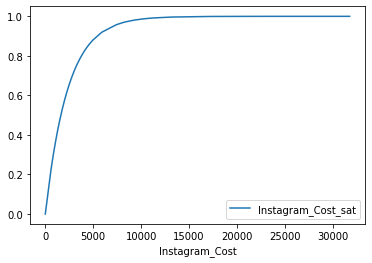

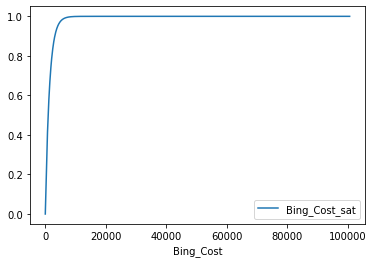

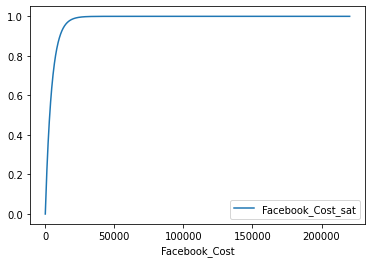

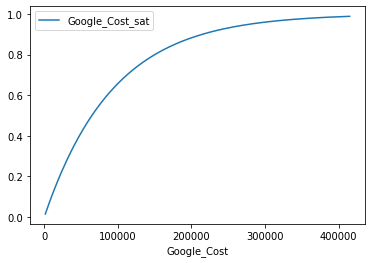

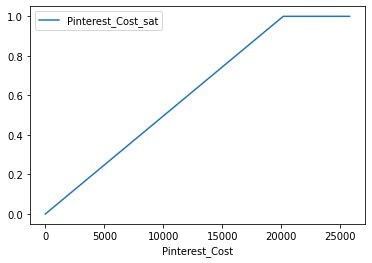

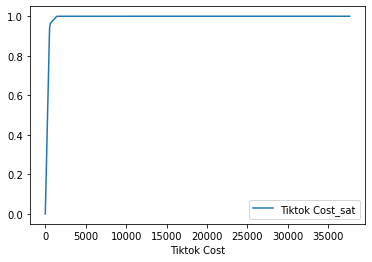

In [ ]:
df_SATURATED.sort_values(by=['Instagram_Cost']).plot(x='Instagram_Cost', y='Instagram_Cost_sat')
df_SATURATED.sort_values(by=['Bing_Cost']).plot(x='Bing_Cost', y='Bing_Cost_sat')
df_SATURATED.sort_values(by=['Facebook_Cost']).plot(x='Facebook_Cost', y='Facebook_Cost_sat')
df_SATURATED.sort_values(by=['Google_Cost']).plot(x='Google_Cost', y='Google_Cost_sat')
df_SATURATED.sort_values(by=['Pinterest_Cost']).plot(x='Pinterest_Cost', y='Pinterest_Cost_sat')
df_SATURATED.sort_values(by=['Tiktok Cost']).plot(x='Tiktok Cost', y='Tiktok Cost_sat')
plt.show()

In [ ]:
'''
{'adstock__Instagram_pipe__carryover__strength': 0.06134275212076826, 'adstock__Instagram_pipe__carryover__length': 6, 'adstock__Instagram_pipe__saturation__a': 0.0006583037029892681, 'adstock__Bing_pipe__carryover__strength': 0.7831597101143383, 'adstock__Bing_pipe__carryover__length': 4, 'adstock__Bing_pipe__saturation__a': 0.00018076971334208248, 'adstock__Facebook_pipe__carryover__strength': 0.9937462300443269, 'adstock__Facebook_pipe__carryover__length': 2, 'adstock__Facebook_pipe__saturation__a': 0.00044714325130749174, 'adstock__Google_pipe__carryover__strength': 0.8614548263017408, 'adstock__Google_pipe__carryover__length': 5, 'adstock__Google_pipe__saturation__a': 0.009112413936257708, 'adstock__Pinterest_pipe__carryover__strength': 0.28552977661268747, 'adstock__Pinterest_pipe__carryover__length': 5, 'adstock__Pinterest_pipe__saturation__a': 0.0015658692167420571, 'adstock__TiktoK_pipe__carryover__strength': 0.223888473325318, 'adstock__TiktoK_pipe__carryover__length': 4, 'adstock__TiktoK_pipe__saturation__a': 0.0031069331391932083}
[5.52874097e+03 2.34798821e+03 1.25200861e+03 7.84439180e-12
 2.83804040e+03 2.44024490e+02]
384.1011764467348
'''

"\n{'adstock__Instagram_pipe__carryover__strength': 0.06134275212076826, 'adstock__Instagram_pipe__carryover__length': 6, 'adstock__Instagram_pipe__saturation__a': 0.0006583037029892681, 'adstock__Bing_pipe__carryover__strength': 0.7831597101143383, 'adstock__Bing_pipe__carryover__length': 4, 'adstock__Bing_pipe__saturation__a': 0.00018076971334208248, 'adstock__Facebook_pipe__carryover__strength': 0.9937462300443269, 'adstock__Facebook_pipe__carryover__length': 2, 'adstock__Facebook_pipe__saturation__a': 0.00044714325130749174, 'adstock__Google_pipe__carryover__strength': 0.8614548263017408, 'adstock__Google_pipe__carryover__length': 5, 'adstock__Google_pipe__saturation__a': 0.009112413936257708, 'adstock__Pinterest_pipe__carryover__strength': 0.28552977661268747, 'adstock__Pinterest_pipe__carryover__length': 5, 'adstock__Pinterest_pipe__saturation__a': 0.0015658692167420571, 'adstock__TiktoK_pipe__carryover__strength': 0.223888473325318, 'adstock__TiktoK_pipe__carryover__length': 4, 